# Previs√£o de Inadimpl√™ncia de Clientes

A inadimpl√™ncia √© um dos maiores desafios enfrentados por empresas que oferecem cr√©dito ou realizam cobran√ßas peri√≥dicas. Quando um cliente atrasa ou deixa de pagar uma obriga√ß√£o financeira, a empresa n√£o apenas perde receita, como tamb√©m compromete o fluxo de caixa, aumenta seus custos operacionais com cobran√ßa e eleva o risco financeiro da opera√ß√£o.

Al√©m disso, altos √≠ndices de inadimpl√™ncia podem indicar problemas na concess√£o de cr√©dito, falhas no relacionamento com o cliente ou mesmo reflexos de instabilidades econ√¥micas. Identificar com anteced√™ncia os clientes que t√™m maior chance de atrasar seus pagamentos permite a√ß√µes mais eficientes, como contato proativo, renegocia√ß√£o ou revis√£o de limites de cr√©dito.

Diante disso, algumas perguntas importantes surgem:

- Quais caracter√≠sticas dos clientes est√£o mais associadas √† inadimpl√™ncia?
- √â poss√≠vel prever a inadimpl√™ncia antes que o atraso ocorra?
- Existe um padr√£o comportamental que antecede o n√£o pagamento?
- Como transformar essas informa√ß√µes em a√ß√µes pr√°ticas para reduzir perdas?

Neste projeto, ser√° desenvolvida uma solu√ß√£o baseada em dados que visa prever a probabilidade de inadimpl√™ncia em cobran√ßas mensais realizadas a clientes, com base em seus hist√≥ricos de pagamento, informa√ß√µes cadastrais e indicadores mensais.

O objetivo final √© permitir que a empresa possa priorizar a√ß√µes de cobran√ßa de forma mais inteligente e eficiente, reduzindo riscos e melhorando seus resultados financeiros.

## 1 - Importa√ß√£o das bibliotecas necess√°rias

In [1]:
# Importa√ß√£o das bibliotecas 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from dateutil.relativedelta import relativedelta
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix

# 2 - Pr√©-processamento dos dados

In [2]:
# Leitura e visualiza√ß√£o de algumas informa√ß√µes dos dados

# informa√ß√µes de cadastro
cadastros = pd.read_csv('data/base_cadastral.csv', parse_dates=["DATA_CADASTRO"],
                        sep=';')
cadastros.info()
print(f'\nN√∫mero de linhas duplicadas: {cadastros.duplicated().sum()}\n')

# informa√ß√µes sobre os clientes

infos = pd.read_csv('data/base_info.csv', parse_dates=["SAFRA_REF"], sep=';')
infos.info()
print(f'\nN√∫mero de linhas duplicadas: {infos.duplicated().sum()}\n')

# base de pagamentos (desenvolvimento)

pagamentos_dev = pd.read_csv('data/base_pagamentos_desenvolvimento.csv', parse_dates=["DATA_EMISSAO_DOCUMENTO", "DATA_VENCIMENTO", 
                                                                                      "DATA_PAGAMENTO", "SAFRA_REF"],
                             sep=';')
pagamentos_dev.info()
print(f'\nN√∫mero de linhas duplicadas: {pagamentos_dev.duplicated().sum()}\n')

# base de pagamentos (teste)
pagamentos_teste = pd.read_csv('data/base_pagamentos_teste.csv', parse_dates=["DATA_EMISSAO_DOCUMENTO", "DATA_VENCIMENTO", "SAFRA_REF"],
                               sep=';')
pagamentos_teste.info()
print(f'\nN√∫mero de linhas duplicadas: {pagamentos_teste.duplicated().sum()}\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_CLIENTE           1315 non-null   int64         
 1   DATA_CADASTRO        1315 non-null   datetime64[ns]
 2   DDD                  1078 non-null   object        
 3   FLAG_PF              66 non-null     object        
 4   SEGMENTO_INDUSTRIAL  1232 non-null   object        
 5   DOMINIO_EMAIL        1285 non-null   object        
 6   PORTE                1274 non-null   object        
 7   CEP_2_DIG            1315 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 82.3+ KB

N√∫mero de linhas duplicadas: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24401 entries, 0 to 24400
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         


Observando as informa√ß√µes sobre os dados, podemos chegar √†s seguintes conclus√µes:

1- Para a base com informa√ß√µes de cadastro (**base_cadastral.csv**), podemos observar:
- Muitos valores nulos na coluna `FLAG_PF`, por√©m, j√° era de se esperar, pois os clientes que s√£o do tipo PJ est√£o marcados com a flag de valor nulo, ao contr√°rio dos clientes do tipo PF, que t√™m valor atribu√≠do. A coluna ent√£o ser√° reformulada para ter valores 1 para PF e 0 para PJ;
-  Valores nulos na coluna `DDD`, que possui import√¢ncia por trazer informa√ß√µes sobre localiza√ß√£o geogr√°fica do cliente atrav√©s do DDD, que pode se mostrar importante na an√°lise de poss√≠vel inadimpl√™ncia. Nesse caso, os valores nulos ser√£o preenchidos com 'OUTRO';
- Valores nulos nas colunas `SEGMENTO_INDUSTRIAL`, `DOMINIO_EMAIL` e `PORTE` ser√£o tamb√©m substitu√≠dos por 'OUTRO', preservando registros que, mesmo incompletos, podem conter informa√ß√µes relevantes para o aprendizado do modelo;
- Como n√£o h√° linhas duplicadas, nada ser√° feito em rela√ß√£o a isso;

2- Para a base com informa√ß√µes adicionais sobre o cliente (**base_info.csv**), podemos observar:
- Valores nulos na coluna `RENDA_MES_ANTERIOR`, que contem informa√ß√µes importantes para previs√£o de inadimpl√™ncia. As informa√ß√µes faltantes ser√£o preenchidas com a mediana das rendas hist√≥ricas do pr√≥prio cliente, reduzindo o impacto de outliers. Caso o cliente n√£o possua registros suficientes para o c√°lculo da mediana, a informa√ß√£o sobre a renda mensal ser√° preenchida com 0. A aus√™ncia dos valores ser√° marcada com uma coluna flag `RENDA_MES_ANTERIOR_NULO` para marcar a aus√™ncia de informa√ß√£o;
- Valores nulos na coluna `NO_FUNCIONARIOS`, que, considerando o contexto da base cadastral, podem estar associados a clientes do tipo PF. Esses valores ser√£o preenchidos com 0 e ser√° criada uma flag `NO_FUNCIONARIOS_NULO` para sinalizar os registros originalmente ausentes, permitindo ao modelo capturar poss√≠veis implica√ß√µes.

3- Para as base de treinamento e teste com as informa√ß√µes de pagamentos (**base_pagamentos_desenvolvimento.csv**), podemos observar:
- Valores ausentes na coluna `VALOR_A_PAGAR` indicam uma inconsist√™ncia preocupante, j√° que esse valor √© fundamental para compreender o risco de inadimpl√™ncia. Essa aus√™ncia pode ter origem em falha na gera√ß√£o da base ou em outra causa operacional. Independentemente da raz√£o, os valores nulos ser√£o preenchidos com a mediana dos valores cobrados ao cliente espec√≠fico ‚Äî a fim de manter consist√™ncia com o padr√£o individual de cobran√ßa. Na aus√™ncia de hist√≥rico suficiente, ser√° usado o valor 0. Al√©m disso, ser√° criada a coluna `VALOR_A_PAGAR_NULO`, sinalizando que aquela cobran√ßa possui dado ausente. Essa abordagem permite que o modelo diferencie registros t√≠picos de casos com poss√≠vel problema de origem;
- Em ambas as bases observamos linhas completamente id√™nticas. Como representam registros id√™nticos, e n√£o adicionam valor ao aprendizado, ser√£o removidas para evitar vi√©s ou sobre-representa√ß√£o de determinados padr√µes;


In [3]:
## Ajuste da base de cadastros

# ajuste da coluna FLAG_PF

cadastros['FLAG_PF'] = np.where(cadastros['FLAG_PF'] == 'X',
                                1,
                                0).astype('int64')
# ajuste das demais colunas
cadastros[['DDD', 'SEGMENTO_INDUSTRIAL', 
           'DOMINIO_EMAIL', 'PORTE']] = cadastros[['DDD', 'SEGMENTO_INDUSTRIAL', 
                                                   'DOMINIO_EMAIL', 'PORTE']].fillna('OUTROS')

cadastros[['DDD', 'SEGMENTO_INDUSTRIAL', 
           'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG']] = cadastros[['DDD', 'SEGMENTO_INDUSTRIAL', 
                                                                'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG']].astype('category')
cadastros.info()
cadastros.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_CLIENTE           1315 non-null   int64         
 1   DATA_CADASTRO        1315 non-null   datetime64[ns]
 2   DDD                  1315 non-null   category      
 3   FLAG_PF              1315 non-null   int64         
 4   SEGMENTO_INDUSTRIAL  1315 non-null   category      
 5   DOMINIO_EMAIL        1315 non-null   category      
 6   PORTE                1315 non-null   category      
 7   CEP_2_DIG            1315 non-null   category      
dtypes: category(5), datetime64[ns](1), int64(2)
memory usage: 43.5 KB


ID_CLIENTE DATA_CADASTRO DDD  FLAG_PF SEGMENTO_INDUSTRIAL  \
0  1661240395903230676    2013-08-22  99        0            Servi√ßos   
1  8274986328479596038    2017-01-25  31        0            Com√©rcio   
2   345447888460137901    2000-08-15  75        0            Servi√ßos   
3  1003144834589372198    2017-08-06  49        0            Servi√ßos   
4   324916756972236008    2011-02-14  88        0            Servi√ßos   
5  4679462479444735708    2000-08-15  18        0           Ind√∫stria   
6  1276604410881911401    2000-08-15  67        0           Ind√∫stria   
7  8123515208041701633    2011-02-14  21        0            Servi√ßos   
8  4530631557358349711    2000-08-15  11        0            Servi√ßos   
9  3668905663669864663    2011-02-14  44        0            Com√©rcio   

  DOMINIO_EMAIL    PORTE CEP_2_DIG  
0         YAHOO  PEQUENO        65  
1         YAHOO    MEDIO        77  
2       HOTMAIL  PEQUENO        48  
3       OUTLOOK  PEQUENO        89  
4         GMAIL   GRANDE        62  
5       HOTMAIL   GRANDE        19  
6         YAHOO  PEQUENO        38  
7         GMAIL  PEQUENO        26  
8       HOTMAIL  PEQUENO        55  
9           BOL   GRANDE        87

In [4]:
# gera√ß√£o de coluna reutiliz√°vel para preenchimento de valores nulos
def preencher_com_mediana_por_cliente(df, coluna, criar_flag=True):
    """
    Preenche valores nulos de uma coluna num√©rica com a mediana por ID_CLIENTE.
    Se o cliente n√£o tiver mediana dispon√≠vel, preenche com a mediana geral da coluna.
    
    Par√¢metros:
    - df (pd.DataFrame): DataFrame de entrada (deve conter 'ID_CLIENTE')
    - coluna (str): nome da coluna num√©rica a ser preenchida
    - criar_flag (bool): se True, cria uma coluna booleana {coluna}_NULO indicando valores originalmente ausentes
    
    Retorna:
    - df (pd.DataFrame): DataFrame com coluna preenchida e (opcionalmente) a flag de nulo
    """
    df = df.copy()

    # 1. Cria flag de valor ausente, se desejado
    if criar_flag:
        df[f'{coluna}_NULO'] = df[coluna].isna().astype('int64')
    
    # 2. Calcula a mediana da coluna por cliente
    mediana_por_cliente = df.groupby('ID_CLIENTE')[coluna].median()

    # 3. Mapeia a mediana para cada linha do DataFrame
    df[f'{coluna}_MEDIANA_CLIENTE'] = df['ID_CLIENTE'].map(mediana_por_cliente)

    # 4. Preenche os nulos com a mediana do cliente
    df[coluna] = df[coluna].fillna(df[f'{coluna}_MEDIANA_CLIENTE'])

    # 5. Preenche valores ainda nulos com 0
    df[coluna] = df[coluna].fillna(0)

    # 6. Remove a coluna auxiliar
    df = df.drop(columns=[f'{coluna}_MEDIANA_CLIENTE'])

    return df

In [5]:
## Ajuste da base com informa√ß√µes dos clientes

infos = preencher_com_mediana_por_cliente(infos, 'RENDA_MES_ANTERIOR')
infos['NO_FUNCIONARIOS_NULO'] = infos['NO_FUNCIONARIOS'].isna().astype('int64')
infos['NO_FUNCIONARIOS'] = infos['NO_FUNCIONARIOS'].fillna(0)

infos.info()
infos.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24401 entries, 0 to 24400
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID_CLIENTE               24401 non-null  int64         
 1   SAFRA_REF                24401 non-null  datetime64[ns]
 2   RENDA_MES_ANTERIOR       24401 non-null  float64       
 3   NO_FUNCIONARIOS          24401 non-null  float64       
 4   RENDA_MES_ANTERIOR_NULO  24401 non-null  int64         
 5   NO_FUNCIONARIOS_NULO     24401 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 1.1 MB


ID_CLIENTE  SAFRA_REF  RENDA_MES_ANTERIOR  NO_FUNCIONARIOS  \
0  1661240395903230676 2018-09-01             16913.0              0.0   
1  8274986328479596038 2018-09-01            106430.0            141.0   
2   345447888460137901 2018-09-01            707439.0             99.0   
3  1003144834589372198 2018-09-01            239659.0             96.0   
4   324916756972236008 2018-09-01            203123.0            103.0   
5  4679462479444735708 2018-09-01             53021.0            120.0   
6  1276604410881911401 2018-09-01             97117.0             79.0   
7  8123515208041701633 2018-09-01            142410.0             72.0   
8  4530631557358349711 2018-09-01            185040.0            101.0   
9  3668905663669864663 2018-09-01            331138.0            137.0   

   RENDA_MES_ANTERIOR_NULO  NO_FUNCIONARIOS_NULO  
0                        0                     1  
1                        0                     0  
2                        0                     0  
3                        0                     0  
4                        0                     0  
5                        0                     0  
6                        0                     0  
7                        0                     0  
8                        0                     0  
9                        0                     0

In [6]:
## Ajuste da base de pagamentos (desenvolvimento)

pagamentos_dev = preencher_com_mediana_por_cliente(pagamentos_dev, 'VALOR_A_PAGAR')
pagamentos_dev.drop_duplicates(inplace=True)

pagamentos_dev.info()
pagamentos_dev.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 77413 entries, 0 to 77413
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID_CLIENTE              77413 non-null  int64         
 1   SAFRA_REF               77413 non-null  datetime64[ns]
 2   DATA_EMISSAO_DOCUMENTO  77413 non-null  datetime64[ns]
 3   DATA_PAGAMENTO          77413 non-null  datetime64[ns]
 4   DATA_VENCIMENTO         77413 non-null  datetime64[ns]
 5   VALOR_A_PAGAR           77413 non-null  float64       
 6   TAXA                    77413 non-null  float64       
 7   VALOR_A_PAGAR_NULO      77413 non-null  int64         
dtypes: datetime64[ns](4), float64(2), int64(2)
memory usage: 5.3 MB


ID_CLIENTE  SAFRA_REF DATA_EMISSAO_DOCUMENTO DATA_PAGAMENTO  \
0  1661240395903230676 2018-08-01             2018-08-17     2018-09-06   
1  1661240395903230676 2018-08-01             2018-08-19     2018-09-11   
2  1661240395903230676 2018-08-01             2018-08-26     2018-09-18   
3  1661240395903230676 2018-08-01             2018-08-30     2018-10-11   
4  1661240395903230676 2018-08-01             2018-08-31     2018-09-20   
5  8274986328479596038 2018-08-01             2018-08-17     2018-09-25   
6   345447888460137901 2018-08-01             2018-08-17     2018-09-05   
7  1003144834589372198 2018-08-01             2018-08-17     2018-09-03   
8   324916756972236008 2018-08-01             2018-08-17     2018-09-03   
9   324916756972236008 2018-08-01             2018-08-19     2018-09-05   

  DATA_VENCIMENTO  VALOR_A_PAGAR  TAXA  VALOR_A_PAGAR_NULO  
0      2018-09-06       35516.41  6.99                   0  
1      2018-09-10       17758.21  6.99                   0  
2      2018-09-17       17431.96  6.99                   0  
3      2018-10-05        1341.00  6.99                   0  
4      2018-09-20       21309.85  6.99                   0  
5      2018-09-25       48811.35  6.99                   0  
6      2018-09-05       55131.20  5.99                   0  
7      2018-09-03       85855.04  6.99                   0  
8      2018-09-03       42072.00  5.99                   0  
9      2018-09-05       21071.97  5.99                   0

In [7]:
## Ajuste da base de pagamentos (teste)

pagamentos_teste = preencher_com_mediana_por_cliente(pagamentos_teste, 'VALOR_A_PAGAR')
pagamentos_teste.drop_duplicates(inplace=True)

pagamentos_teste.info()
pagamentos_teste.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 12264 entries, 0 to 12274
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID_CLIENTE              12264 non-null  int64         
 1   SAFRA_REF               12264 non-null  datetime64[ns]
 2   DATA_EMISSAO_DOCUMENTO  12264 non-null  datetime64[ns]
 3   DATA_VENCIMENTO         12264 non-null  datetime64[ns]
 4   VALOR_A_PAGAR           12264 non-null  float64       
 5   TAXA                    12264 non-null  float64       
 6   VALOR_A_PAGAR_NULO      12264 non-null  int64         
dtypes: datetime64[ns](3), float64(2), int64(2)
memory usage: 766.5 KB


ID_CLIENTE  SAFRA_REF DATA_EMISSAO_DOCUMENTO DATA_VENCIMENTO  \
0  5058298901476893676 2021-07-01             2021-07-14      2021-08-04   
1   274692171162531764 2021-07-01             2021-07-08      2021-08-23   
2   274692171162531764 2021-07-01             2021-07-11      2021-08-25   
3   274692171162531764 2021-07-01             2021-07-16      2021-08-30   
4   465309249432033993 2021-07-01             2021-07-05      2021-07-30   
5   465309249432033993 2021-07-01             2021-07-09      2021-08-03   
6   465309249432033993 2021-07-01             2021-07-13      2021-08-09   
7   465309249432033993 2021-07-01             2021-07-13      2021-08-09   
8  5883155883105348987 2021-07-01             2021-07-03      2021-07-22   
9  5883155883105348987 2021-07-01             2021-07-08      2021-07-26   

   VALOR_A_PAGAR  TAXA  VALOR_A_PAGAR_NULO  
0       11204.75  4.99                   0  
1       60718.50  5.99                   0  
2       60718.50  5.99                   0  
3       62250.00  5.99                   0  
4       26593.95  6.99                   0  
5       26012.44  6.99                   0  
6       26082.54  6.99                   0  
7       26738.12  6.99                   0  
8       20260.27  8.99                   0  
9       19043.82  8.99                   0

In [8]:
# adi√ß√£o da coluna alvo na base de treinamento

pagamentos_dev['INADIMPLENTE'] = np.where((pagamentos_dev['DATA_PAGAMENTO'] - pagamentos_dev['DATA_VENCIMENTO']).dt.days >= 5,
                                          1,
                                          0).astype('int64') # 1 para inadimplente, 0 para adimplente

pagamentos_dev.info()
pagamentos_dev.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 77413 entries, 0 to 77413
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID_CLIENTE              77413 non-null  int64         
 1   SAFRA_REF               77413 non-null  datetime64[ns]
 2   DATA_EMISSAO_DOCUMENTO  77413 non-null  datetime64[ns]
 3   DATA_PAGAMENTO          77413 non-null  datetime64[ns]
 4   DATA_VENCIMENTO         77413 non-null  datetime64[ns]
 5   VALOR_A_PAGAR           77413 non-null  float64       
 6   TAXA                    77413 non-null  float64       
 7   VALOR_A_PAGAR_NULO      77413 non-null  int64         
 8   INADIMPLENTE            77413 non-null  int64         
dtypes: datetime64[ns](4), float64(2), int64(3)
memory usage: 5.9 MB


ID_CLIENTE  SAFRA_REF DATA_EMISSAO_DOCUMENTO DATA_PAGAMENTO  \
0  1661240395903230676 2018-08-01             2018-08-17     2018-09-06   
1  1661240395903230676 2018-08-01             2018-08-19     2018-09-11   
2  1661240395903230676 2018-08-01             2018-08-26     2018-09-18   
3  1661240395903230676 2018-08-01             2018-08-30     2018-10-11   
4  1661240395903230676 2018-08-01             2018-08-31     2018-09-20   
5  8274986328479596038 2018-08-01             2018-08-17     2018-09-25   
6   345447888460137901 2018-08-01             2018-08-17     2018-09-05   
7  1003144834589372198 2018-08-01             2018-08-17     2018-09-03   
8   324916756972236008 2018-08-01             2018-08-17     2018-09-03   
9   324916756972236008 2018-08-01             2018-08-19     2018-09-05   

  DATA_VENCIMENTO  VALOR_A_PAGAR  TAXA  VALOR_A_PAGAR_NULO  INADIMPLENTE  
0      2018-09-06       35516.41  6.99                   0             0  
1      2018-09-10       17758.21  6.99                   0             0  
2      2018-09-17       17431.96  6.99                   0             0  
3      2018-10-05        1341.00  6.99                   0             1  
4      2018-09-20       21309.85  6.99                   0             0  
5      2018-09-25       48811.35  6.99                   0             0  
6      2018-09-05       55131.20  5.99                   0             0  
7      2018-09-03       85855.04  6.99                   0             0  
8      2018-09-03       42072.00  5.99                   0             0  
9      2018-09-05       21071.97  5.99                   0             0

In [9]:
# gerando base de dados final para treinamento do modelo

base_dev = pagamentos_dev.merge(cadastros, 
                                on='ID_CLIENTE',
                                how='left').drop_duplicates().merge(infos,
                                                  on=['ID_CLIENTE', 'SAFRA_REF'],
                                                  how='left').drop_duplicates()

base_dev.info()
base_dev.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77413 entries, 0 to 77412
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID_CLIENTE               77413 non-null  int64         
 1   SAFRA_REF                77413 non-null  datetime64[ns]
 2   DATA_EMISSAO_DOCUMENTO   77413 non-null  datetime64[ns]
 3   DATA_PAGAMENTO           77413 non-null  datetime64[ns]
 4   DATA_VENCIMENTO          77413 non-null  datetime64[ns]
 5   VALOR_A_PAGAR            77413 non-null  float64       
 6   TAXA                     77413 non-null  float64       
 7   VALOR_A_PAGAR_NULO       77413 non-null  int64         
 8   INADIMPLENTE             77413 non-null  int64         
 9   DATA_CADASTRO            77413 non-null  datetime64[ns]
 10  DDD                      77413 non-null  category      
 11  FLAG_PF                  77413 non-null  int64         
 12  SEGMENTO_INDUSTRIAL      77413 n

ID_CLIENTE  SAFRA_REF DATA_EMISSAO_DOCUMENTO DATA_PAGAMENTO  \
0  1661240395903230676 2018-08-01             2018-08-17     2018-09-06   
1  1661240395903230676 2018-08-01             2018-08-19     2018-09-11   
2  1661240395903230676 2018-08-01             2018-08-26     2018-09-18   
3  1661240395903230676 2018-08-01             2018-08-30     2018-10-11   
4  1661240395903230676 2018-08-01             2018-08-31     2018-09-20   
5  8274986328479596038 2018-08-01             2018-08-17     2018-09-25   
6   345447888460137901 2018-08-01             2018-08-17     2018-09-05   
7  1003144834589372198 2018-08-01             2018-08-17     2018-09-03   
8   324916756972236008 2018-08-01             2018-08-17     2018-09-03   
9   324916756972236008 2018-08-01             2018-08-19     2018-09-05   

  DATA_VENCIMENTO  VALOR_A_PAGAR  TAXA  VALOR_A_PAGAR_NULO  INADIMPLENTE  \
0      2018-09-06       35516.41  6.99                   0             0   
1      2018-09-10       17758.21  6.99                   0             0   
2      2018-09-17       17431.96  6.99                   0             0   
3      2018-10-05        1341.00  6.99                   0             1   
4      2018-09-20       21309.85  6.99                   0             0   
5      2018-09-25       48811.35  6.99                   0             0   
6      2018-09-05       55131.20  5.99                   0             0   
7      2018-09-03       85855.04  6.99                   0             0   
8      2018-09-03       42072.00  5.99                   0             0   
9      2018-09-05       21071.97  5.99                   0             0   

  DATA_CADASTRO DDD  FLAG_PF SEGMENTO_INDUSTRIAL DOMINIO_EMAIL    PORTE  \
0    2013-08-22  99        0            Servi√ßos         YAHOO  PEQUENO   
1    2013-08-22  99        0            Servi√ßos         YAHOO  PEQUENO   
2    2013-08-22  99        0            Servi√ßos         YAHOO  PEQUENO   
3    2013-08-22  99        0            Servi√ßos         YAHOO  PEQUENO   
4    2013-08-22  99        0            Servi√ßos         YAHOO  PEQUENO   
5    2017-01-25  31        0            Com√©rcio         YAHOO    MEDIO   
6    2000-08-15  75        0            Servi√ßos       HOTMAIL  PEQUENO   
7    2017-08-06  49        0            Servi√ßos       OUTLOOK  PEQUENO   
8    2011-02-14  88        0            Servi√ßos         GMAIL   GRANDE   
9    2011-02-14  88        0            Servi√ßos         GMAIL   GRANDE   

  CEP_2_DIG  RENDA_MES_ANTERIOR  NO_FUNCIONARIOS  RENDA_MES_ANTERIOR_NULO  \
0        65                 NaN              NaN                      NaN   
1        65                 NaN              NaN                      NaN   
2        65                 NaN              NaN                      NaN   
3        65                 NaN              NaN                      NaN   
4        65                 NaN              NaN                      NaN   
5        77                 NaN              NaN                      NaN   
6        48                 NaN              NaN                      NaN   
7        89                 NaN              NaN                      NaN   
8        62                 NaN              NaN                      NaN   
9        62                 NaN              NaN                      NaN   

   NO_FUNCIONARIOS_NULO  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
5                   NaN  
6                   NaN  
7                   NaN  
8                   NaN  
9                   NaN

In [10]:
# gerando base de dados final para treinamento do modelo

base_teste = pagamentos_teste.merge(cadastros, 
                                on='ID_CLIENTE',
                                how='left').drop_duplicates().merge(infos,
                                                  on=['ID_CLIENTE', 'SAFRA_REF'],
                                                  how='left').drop_duplicates()

base_teste.info()
base_teste.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12264 entries, 0 to 12263
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID_CLIENTE               12264 non-null  int64         
 1   SAFRA_REF                12264 non-null  datetime64[ns]
 2   DATA_EMISSAO_DOCUMENTO   12264 non-null  datetime64[ns]
 3   DATA_VENCIMENTO          12264 non-null  datetime64[ns]
 4   VALOR_A_PAGAR            12264 non-null  float64       
 5   TAXA                     12264 non-null  float64       
 6   VALOR_A_PAGAR_NULO       12264 non-null  int64         
 7   DATA_CADASTRO            12226 non-null  datetime64[ns]
 8   DDD                      12226 non-null  category      
 9   FLAG_PF                  12226 non-null  float64       
 10  SEGMENTO_INDUSTRIAL      12226 non-null  category      
 11  DOMINIO_EMAIL            12226 non-null  category      
 12  PORTE                    12226 n

ID_CLIENTE  SAFRA_REF DATA_EMISSAO_DOCUMENTO DATA_VENCIMENTO  \
0  5058298901476893676 2021-07-01             2021-07-14      2021-08-04   
1   274692171162531764 2021-07-01             2021-07-08      2021-08-23   
2   274692171162531764 2021-07-01             2021-07-11      2021-08-25   
3   274692171162531764 2021-07-01             2021-07-16      2021-08-30   
4   465309249432033993 2021-07-01             2021-07-05      2021-07-30   
5   465309249432033993 2021-07-01             2021-07-09      2021-08-03   
6   465309249432033993 2021-07-01             2021-07-13      2021-08-09   
7   465309249432033993 2021-07-01             2021-07-13      2021-08-09   
8  5883155883105348987 2021-07-01             2021-07-03      2021-07-22   
9  5883155883105348987 2021-07-01             2021-07-08      2021-07-26   

   VALOR_A_PAGAR  TAXA  VALOR_A_PAGAR_NULO DATA_CADASTRO DDD  FLAG_PF  \
0       11204.75  4.99                   0    2014-03-30  54      0.0   
1       60718.50  5.99                   0    2005-08-03  19      0.0   
2       60718.50  5.99                   0    2005-08-03  19      0.0   
3       62250.00  5.99                   0    2005-08-03  19      0.0   
4       26593.95  6.99                   0    2014-07-23  69      0.0   
5       26012.44  6.99                   0    2014-07-23  69      0.0   
6       26082.54  6.99                   0    2014-07-23  69      0.0   
7       26738.12  6.99                   0    2014-07-23  69      0.0   
8       20260.27  8.99                   0    2011-02-14  11      0.0   
9       19043.82  8.99                   0    2011-02-14  11      0.0   

  SEGMENTO_INDUSTRIAL DOMINIO_EMAIL    PORTE CEP_2_DIG  RENDA_MES_ANTERIOR  \
0            Servi√ßos         GMAIL    MEDIO        99            467430.0   
1            Servi√ßos         GMAIL  PEQUENO        13            417192.0   
2            Servi√ßos         GMAIL  PEQUENO        13            417192.0   
3            Servi√ßos         GMAIL  PEQUENO        13            417192.0   
4            Com√©rcio         GMAIL   GRANDE        76            873938.0   
5            Com√©rcio         GMAIL   GRANDE        76            873938.0   
6            Com√©rcio         GMAIL   GRANDE        76            873938.0   
7            Com√©rcio         GMAIL   GRANDE        76            873938.0   
8            Com√©rcio         GMAIL  PEQUENO        42            471300.0   
9            Com√©rcio         GMAIL  PEQUENO        42            471300.0   

   NO_FUNCIONARIOS  RENDA_MES_ANTERIOR_NULO  NO_FUNCIONARIOS_NULO  
0              0.0                      0.0                   1.0  
1            104.0                      0.0                   0.0  
2            104.0                      0.0                   0.0  
3            104.0                      0.0                   0.0  
4            119.0                      0.0                   0.0  
5            119.0                      0.0                   0.0  
6            119.0                      0.0                   0.0  
7            119.0                      0.0                   0.0  
8            143.0                      0.0                   0.0  
9            143.0                      0.0                   0.0

In [11]:
# observando um caso com valores nulos

nulos_dev_id = base_dev[base_dev['RENDA_MES_ANTERIOR'].isnull()]['ID_CLIENTE'].values[1]

print(pagamentos_dev[pagamentos_dev['ID_CLIENTE'] == nulos_dev_id]['SAFRA_REF'].unique())

print(infos[infos['ID_CLIENTE'] == nulos_dev_id]['SAFRA_REF'].unique())

<DatetimeArray>
['2018-08-01 00:00:00', '2018-09-01 00:00:00', '2018-10-01 00:00:00',
 '2018-11-01 00:00:00', '2018-12-01 00:00:00', '2019-01-01 00:00:00',
 '2019-02-01 00:00:00', '2019-03-01 00:00:00', '2019-04-01 00:00:00',
 '2019-05-01 00:00:00', '2019-06-01 00:00:00', '2019-07-01 00:00:00',
 '2019-08-01 00:00:00', '2019-09-01 00:00:00', '2019-10-01 00:00:00',
 '2019-11-01 00:00:00', '2019-12-01 00:00:00', '2020-01-01 00:00:00',
 '2020-02-01 00:00:00', '2020-04-01 00:00:00', '2020-05-01 00:00:00',
 '2020-06-01 00:00:00', '2020-07-01 00:00:00', '2020-08-01 00:00:00',
 '2020-09-01 00:00:00', '2020-10-01 00:00:00', '2020-11-01 00:00:00',
 '2020-12-01 00:00:00', '2021-01-01 00:00:00', '2021-02-01 00:00:00',
 '2021-03-01 00:00:00', '2021-04-01 00:00:00', '2021-05-01 00:00:00',
 '2021-06-01 00:00:00']
Length: 34, dtype: datetime64[ns]
<DatetimeArray>
['2018-09-01 00:00:00', '2018-10-01 00:00:00', '2018-11-01 00:00:00',
 '2018-12-01 00:00:00', '2019-01-01 00:00:00', '2019-02-01 00:00:00',


Apesar do preenchimento pr√©vio dos valores ausentes nas bases originais, ainda foram identificados registros com valores nulos nas colunas `RENDA_MES_ANTERIOR` e `NO_FUNCIONARIOS` ap√≥s a jun√ß√£o final das tabelas. Isso tamb√©m se reflete nas flags associadas a essas vari√°veis, que permanecem com valores nulos.

Essa situa√ß√£o ocorre porque nem todos os meses com informa√ß√µes de pagamento t√™m correspond√™ncia na base de informa√ß√µes mensais ‚Äî ou seja, existem casos em que o cliente possui uma cobran√ßa registrada, mas n√£o h√° informa√ß√µes dispon√≠veis para aquele m√™s espec√≠fico.

Diante disso, e seguindo as diretrizes j√° estabelecidas anteriormente, ser√° reaplicada a l√≥gica de preenchimento com a mediana por cliente (ou valor zero, quando necess√°rio), garantindo consist√™ncia nos dados e evitando a exclus√£o de registros potencialmente √∫teis para a modelagem.

In [12]:
# ajustando a base de dados final de desenvolvimento

base_dev = preencher_com_mediana_por_cliente(base_dev, 'RENDA_MES_ANTERIOR')
base_dev['NO_FUNCIONARIOS_NULO'] = base_dev['NO_FUNCIONARIOS'].isna().astype('int64')
base_dev['NO_FUNCIONARIOS']= base_dev['NO_FUNCIONARIOS'].fillna(0)

base_dev.info()
base_dev.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77413 entries, 0 to 77412
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID_CLIENTE               77413 non-null  int64         
 1   SAFRA_REF                77413 non-null  datetime64[ns]
 2   DATA_EMISSAO_DOCUMENTO   77413 non-null  datetime64[ns]
 3   DATA_PAGAMENTO           77413 non-null  datetime64[ns]
 4   DATA_VENCIMENTO          77413 non-null  datetime64[ns]
 5   VALOR_A_PAGAR            77413 non-null  float64       
 6   TAXA                     77413 non-null  float64       
 7   VALOR_A_PAGAR_NULO       77413 non-null  int64         
 8   INADIMPLENTE             77413 non-null  int64         
 9   DATA_CADASTRO            77413 non-null  datetime64[ns]
 10  DDD                      77413 non-null  category      
 11  FLAG_PF                  77413 non-null  int64         
 12  SEGMENTO_INDUSTRIAL      77413 n

ID_CLIENTE  SAFRA_REF DATA_EMISSAO_DOCUMENTO DATA_PAGAMENTO  \
0  1661240395903230676 2018-08-01             2018-08-17     2018-09-06   
1  1661240395903230676 2018-08-01             2018-08-19     2018-09-11   
2  1661240395903230676 2018-08-01             2018-08-26     2018-09-18   
3  1661240395903230676 2018-08-01             2018-08-30     2018-10-11   
4  1661240395903230676 2018-08-01             2018-08-31     2018-09-20   
5  8274986328479596038 2018-08-01             2018-08-17     2018-09-25   
6   345447888460137901 2018-08-01             2018-08-17     2018-09-05   
7  1003144834589372198 2018-08-01             2018-08-17     2018-09-03   
8   324916756972236008 2018-08-01             2018-08-17     2018-09-03   
9   324916756972236008 2018-08-01             2018-08-19     2018-09-05   

  DATA_VENCIMENTO  VALOR_A_PAGAR  TAXA  VALOR_A_PAGAR_NULO  INADIMPLENTE  \
0      2018-09-06       35516.41  6.99                   0             0   
1      2018-09-10       17758.21  6.99                   0             0   
2      2018-09-17       17431.96  6.99                   0             0   
3      2018-10-05        1341.00  6.99                   0             1   
4      2018-09-20       21309.85  6.99                   0             0   
5      2018-09-25       48811.35  6.99                   0             0   
6      2018-09-05       55131.20  5.99                   0             0   
7      2018-09-03       85855.04  6.99                   0             0   
8      2018-09-03       42072.00  5.99                   0             0   
9      2018-09-05       21071.97  5.99                   0             0   

  DATA_CADASTRO DDD  FLAG_PF SEGMENTO_INDUSTRIAL DOMINIO_EMAIL    PORTE  \
0    2013-08-22  99        0            Servi√ßos         YAHOO  PEQUENO   
1    2013-08-22  99        0            Servi√ßos         YAHOO  PEQUENO   
2    2013-08-22  99        0            Servi√ßos         YAHOO  PEQUENO   
3    2013-08-22  99        0            Servi√ßos         YAHOO  PEQUENO   
4    2013-08-22  99        0            Servi√ßos         YAHOO  PEQUENO   
5    2017-01-25  31        0            Com√©rcio         YAHOO    MEDIO   
6    2000-08-15  75        0            Servi√ßos       HOTMAIL  PEQUENO   
7    2017-08-06  49        0            Servi√ßos       OUTLOOK  PEQUENO   
8    2011-02-14  88        0            Servi√ßos         GMAIL   GRANDE   
9    2011-02-14  88        0            Servi√ßos         GMAIL   GRANDE   

  CEP_2_DIG  RENDA_MES_ANTERIOR  NO_FUNCIONARIOS  RENDA_MES_ANTERIOR_NULO  \
0        65            252109.0              0.0                        1   
1        65            252109.0              0.0                        1   
2        65            252109.0              0.0                        1   
3        65            252109.0              0.0                        1   
4        65            252109.0              0.0                        1   
5        77             83013.0              0.0                        1   
6        48            243615.0              0.0                        1   
7        89            275924.0              0.0                        1   
8        62            244012.0              0.0                        1   
9        62            244012.0              0.0                        1   

   NO_FUNCIONARIOS_NULO  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  
5                     1  
6                     1  
7                     1  
8                     1  
9                     1

In [13]:
# ajustando a base de dados final de teste

base_teste = preencher_com_mediana_por_cliente(base_teste, 'RENDA_MES_ANTERIOR')
base_teste['NO_FUNCIONARIOS_NULO'] = base_teste['NO_FUNCIONARIOS'].isna().astype('int64')
base_teste['NO_FUNCIONARIOS']= base_teste['NO_FUNCIONARIOS'].fillna(0)

base_teste.info()
base_teste.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12264 entries, 0 to 12263
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID_CLIENTE               12264 non-null  int64         
 1   SAFRA_REF                12264 non-null  datetime64[ns]
 2   DATA_EMISSAO_DOCUMENTO   12264 non-null  datetime64[ns]
 3   DATA_VENCIMENTO          12264 non-null  datetime64[ns]
 4   VALOR_A_PAGAR            12264 non-null  float64       
 5   TAXA                     12264 non-null  float64       
 6   VALOR_A_PAGAR_NULO       12264 non-null  int64         
 7   DATA_CADASTRO            12226 non-null  datetime64[ns]
 8   DDD                      12226 non-null  category      
 9   FLAG_PF                  12226 non-null  float64       
 10  SEGMENTO_INDUSTRIAL      12226 non-null  category      
 11  DOMINIO_EMAIL            12226 non-null  category      
 12  PORTE                    12226 n

ID_CLIENTE  SAFRA_REF DATA_EMISSAO_DOCUMENTO DATA_VENCIMENTO  \
0  5058298901476893676 2021-07-01             2021-07-14      2021-08-04   
1   274692171162531764 2021-07-01             2021-07-08      2021-08-23   
2   274692171162531764 2021-07-01             2021-07-11      2021-08-25   
3   274692171162531764 2021-07-01             2021-07-16      2021-08-30   
4   465309249432033993 2021-07-01             2021-07-05      2021-07-30   
5   465309249432033993 2021-07-01             2021-07-09      2021-08-03   
6   465309249432033993 2021-07-01             2021-07-13      2021-08-09   
7   465309249432033993 2021-07-01             2021-07-13      2021-08-09   
8  5883155883105348987 2021-07-01             2021-07-03      2021-07-22   
9  5883155883105348987 2021-07-01             2021-07-08      2021-07-26   

   VALOR_A_PAGAR  TAXA  VALOR_A_PAGAR_NULO DATA_CADASTRO DDD  FLAG_PF  \
0       11204.75  4.99                   0    2014-03-30  54      0.0   
1       60718.50  5.99                   0    2005-08-03  19      0.0   
2       60718.50  5.99                   0    2005-08-03  19      0.0   
3       62250.00  5.99                   0    2005-08-03  19      0.0   
4       26593.95  6.99                   0    2014-07-23  69      0.0   
5       26012.44  6.99                   0    2014-07-23  69      0.0   
6       26082.54  6.99                   0    2014-07-23  69      0.0   
7       26738.12  6.99                   0    2014-07-23  69      0.0   
8       20260.27  8.99                   0    2011-02-14  11      0.0   
9       19043.82  8.99                   0    2011-02-14  11      0.0   

  SEGMENTO_INDUSTRIAL DOMINIO_EMAIL    PORTE CEP_2_DIG  RENDA_MES_ANTERIOR  \
0            Servi√ßos         GMAIL    MEDIO        99            467430.0   
1            Servi√ßos         GMAIL  PEQUENO        13            417192.0   
2            Servi√ßos         GMAIL  PEQUENO        13            417192.0   
3            Servi√ßos         GMAIL  PEQUENO        13            417192.0   
4            Com√©rcio         GMAIL   GRANDE        76            873938.0   
5            Com√©rcio         GMAIL   GRANDE        76            873938.0   
6            Com√©rcio         GMAIL   GRANDE        76            873938.0   
7            Com√©rcio         GMAIL   GRANDE        76            873938.0   
8            Com√©rcio         GMAIL  PEQUENO        42            471300.0   
9            Com√©rcio         GMAIL  PEQUENO        42            471300.0   

   NO_FUNCIONARIOS  RENDA_MES_ANTERIOR_NULO  NO_FUNCIONARIOS_NULO  
0              0.0                        0                     0  
1            104.0                        0                     0  
2            104.0                        0                     0  
3            104.0                        0                     0  
4            119.0                        0                     0  
5            119.0                        0                     0  
6            119.0                        0                     0  
7            119.0                        0                     0  
8            143.0                        0                     0  
9            143.0                        0                     0

Antes de iniciar a etapa de an√°lise explorat√≥ria, √© importante compreender a distribui√ß√£o da vari√°vel alvo `INADIMPLENTE`. 

Essa vari√°vel indica se o pagamento foi realizado com 5 dias ou mais de atraso, sendo:
- `0`: pagamento dentro do prazo
- `1`: inadimpl√™ncia

A visualiza√ß√£o abaixo nos ajuda a entender o grau de desbalanceamento da base, o que poder√° influenciar decis√µes na modelagem.

In [14]:
print(base_dev['INADIMPLENTE'].value_counts(normalize=True))
# Contagem percentual
dist = base_dev['INADIMPLENTE'].value_counts(normalize=True)

# Gr√°fico de barras horizontal
plt.figure(figsize=(6, 3))
dist.plot(kind='barh', color=['blue', 'red'])
plt.title('Distribui√ß√£o da Vari√°vel Alvo (INADIMPLENTE)')
plt.xlabel('Propor√ß√£o')
plt.ylabel('Classe')
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

INADIMPLENTE
0    0.929779
1    0.070221
Name: proportion, dtype: float64


Com a base final devidamente tratada, seguimos agora para a an√°lise explorat√≥ria, buscando entender padr√µes, rela√ß√µes entre vari√°veis e poss√≠veis sinais de inadimpl√™ncia.

## 2- An√°lise Explorat√≥ria

Antes de tudo, vamos olhar algumas estat√≠sticas b√°sicas dos dados.

In [15]:
base_dev.describe(include='all').T  # Para ver estat√≠sticas de todas as colunas

count unique       top   freq  \
ID_CLIENTE               77413.0    NaN       NaN    NaN   
SAFRA_REF                  77413    NaN       NaN    NaN   
DATA_EMISSAO_DOCUMENTO     77413    NaN       NaN    NaN   
DATA_PAGAMENTO             77413    NaN       NaN    NaN   
DATA_VENCIMENTO            77413    NaN       NaN    NaN   
VALOR_A_PAGAR            77413.0    NaN       NaN    NaN   
TAXA                     77413.0    NaN       NaN    NaN   
VALOR_A_PAGAR_NULO       77413.0    NaN       NaN    NaN   
INADIMPLENTE             77413.0    NaN       NaN    NaN   
DATA_CADASTRO              77413    NaN       NaN    NaN   
DDD                        77413     79        11   8583   
FLAG_PF                  77413.0    NaN       NaN    NaN   
SEGMENTO_INDUSTRIAL        77413      4  Servi√ßos  31638   
DOMINIO_EMAIL              77413      7     YAHOO  25322   
PORTE                      77413      4     MEDIO  29929   
CEP_2_DIG                  77413     90        13   3888   
RENDA_MES_ANTERIOR       77413.0    NaN       NaN    NaN   
NO_FUNCIONARIOS          77413.0    NaN       NaN    NaN   
RENDA_MES_ANTERIOR_NULO  77413.0    NaN       NaN    NaN   
NO_FUNCIONARIOS_NULO     77413.0    NaN       NaN    NaN   

                                                  mean                  min  \
ID_CLIENTE                       4662288801698715648.0   8784237149961904.0   
SAFRA_REF                2020-01-19 03:59:24.099053056  2018-08-01 00:00:00   
DATA_EMISSAO_DOCUMENTO   2020-02-02 21:03:20.477956096  2018-08-17 00:00:00   
DATA_PAGAMENTO           2020-02-26 00:38:12.452172288  2018-06-19 00:00:00   
DATA_VENCIMENTO          2020-02-26 04:45:04.103961600  2017-11-27 00:00:00   
VALOR_A_PAGAR                             46543.388422                  0.0   
TAXA                                           6.78962                 4.99   
VALOR_A_PAGAR_NULO                            0.015101                  0.0   
INADIMPLENTE                                  0.070221                  0.0   
DATA_CADASTRO            2010-04-07 09:11:51.089868544  2000-08-15 00:00:00   
DDD                                                NaN                  NaN   
FLAG_PF                                       0.002829                  0.0   
SEGMENTO_INDUSTRIAL                                NaN                  NaN   
DOMINIO_EMAIL                                      NaN                  NaN   
PORTE                                              NaN                  NaN   
CEP_2_DIG                                          NaN                  NaN   
RENDA_MES_ANTERIOR                       287664.158901                  0.0   
NO_FUNCIONARIOS                             106.158358                  0.0   
RENDA_MES_ANTERIOR_NULO                       0.050857                  0.0   
NO_FUNCIONARIOS_NULO                          0.050857                  0.0   

                                           25%                    50%  \
ID_CLIENTE               2369364892942408192.0  4817816966382229504.0   
SAFRA_REF                  2019-05-01 00:00:00    2020-01-01 00:00:00   
DATA_EMISSAO_DOCUMENTO     2019-05-21 00:00:00    2020-01-27 00:00:00   
DATA_PAGAMENTO             2019-06-13 00:00:00    2020-02-19 00:00:00   
DATA_VENCIMENTO            2019-06-13 00:00:00    2020-02-18 00:00:00   
VALOR_A_PAGAR                         18838.08               34762.78   
TAXA                                      5.99                   5.99   
VALOR_A_PAGAR_NULO                         0.0                    0.0   
INADIMPLENTE                               0.0                    0.0   
DATA_CADASTRO              2005-05-05 00:00:00    2011-02-14 00:00:00   
DDD                                        NaN                    NaN   
FLAG_PF                                    0.0                    0.0   
SEGMENTO_INDUSTRIAL                        NaN                    NaN   
DOMINIO_EMAIL                              NaN                    NaN   
PORTE     

Com base nas estat√≠sticas obtidas da base final, podemos destacar os seguintes pontos relevantes:

- A vari√°vel alvo `INADIMPLENTE` est√° fortemente desbalanceada, com aproximadamente **7% de inadimpl√™ncia**. Isso exigir√° aten√ß√£o especial durante a modelagem, como uso de t√©cnicas de reamostragem, ajuste de pesos ou m√©tricas apropriadas.
  
- A coluna `VALOR_A_PAGAR` apresenta **valores extremos (outliers)**, com um m√°ximo de 4,4 milh√µes e desvio padr√£o elevado. Isso pode influenciar negativamente alguns algoritmos e ser√° avaliado com visualiza√ß√µes e, se necess√°rio, com transforma√ß√µes como `log`.

- A vari√°vel `TAXA` possui **baixa variabilidade**, concentrando-se entre 5% e 7%. Isso pode limitar sua capacidade de discriminar inadimpl√™ncia, mas ser√° avaliada na an√°lise bivariada.

- A vari√°vel `FLAG_PF` indica que a **quase totalidade dos clientes s√£o PJ** (~99,7%). Embora seja v√°lida, provavelmente ter√° pouco impacto na previs√£o.

- As colunas `RENDA_MES_ANTERIOR` e `NO_FUNCIONARIOS` apresentam distribui√ß√µes assim√©tricas, com **valores m√°ximos elevados** e desvio padr√£o alto, especialmente no caso da renda. Assim como `VALOR_A_PAGAR`, essas vari√°veis podem exigir transforma√ß√µes.

- As flags `_NULO` criadas para indicar valores ausentes est√£o coerentes e poder√£o ser avaliadas como **indicadores de risco**.

- Vari√°veis categ√≥ricas como `SEGMENTO_INDUSTRIAL`, `DOMINIO_EMAIL`, `PORTE`, `DDD` e `CEP_2_DIG` possuem distribui√ß√µes concentradas em poucos valores (ex: "Servi√ßos", "M√©dio", "YAHOO") e devem ser analisadas com rela√ß√£o √† taxa de inadimpl√™ncia por categoria. Algumas colunas com alta cardinalidade, como `CEP_2_DIG`, podem requerer agrupamento.

A partir das conclus√µes acima, os pr√≥ximos passos da an√°lise explorat√≥ria ser√£o:

1. **An√°lise univariada segmentada por inadimpl√™ncia**, para entender como cada vari√°vel se comporta entre os grupos `inadimplente = 0` e `inadimplente = 1`.

2. **Visualiza√ß√£o de distribui√ß√µes e outliers** para vari√°veis num√©ricas relevantes, com aten√ß√£o especial para `VALOR_A_PAGAR`, `RENDA_MES_ANTERIOR` e `NO_FUNCIONARIOS`.

3. **An√°lise da taxa de inadimpl√™ncia por categoria**, identificando grupos com maior risco e poss√≠veis padr√µes regionais (ex: `DDD` e `CEP_2_DIG`).

4. **Verifica√ß√£o do impacto das flags de aus√™ncia (_NULO)** sobre a inadimpl√™ncia ‚Äî aus√™ncias podem carregar significado estat√≠stico.

5. **An√°lise temporal da inadimpl√™ncia**, utilizando a vari√°vel `SAFRA_REF` para verificar poss√≠veis padr√µes ao longo do tempo.

Essas etapas v√£o ajudar a entender a din√¢mica da base e identificar vari√°veis mais relevantes para a constru√ß√£o do modelo preditivo.


### 2.1 - An√°lise Univariada Segmentada por Inadimpl√™ncia

Para facilitar a an√°lise visual e mitigar o impacto de valores extremos (outliers), as vari√°veis num√©ricas ser√£o transformadas utilizando o logaritmo natural durante a etapa de visualiza√ß√£o. Essa transforma√ß√£o permite uma melhor compara√ß√£o entre os grupos de clientes inadimplentes e adimplentes, evidenciando padr√µes mais claros de distribui√ß√£o.

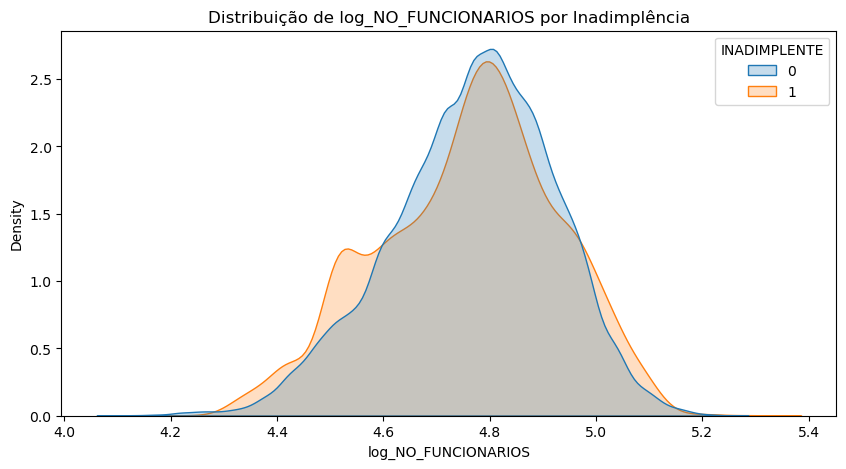

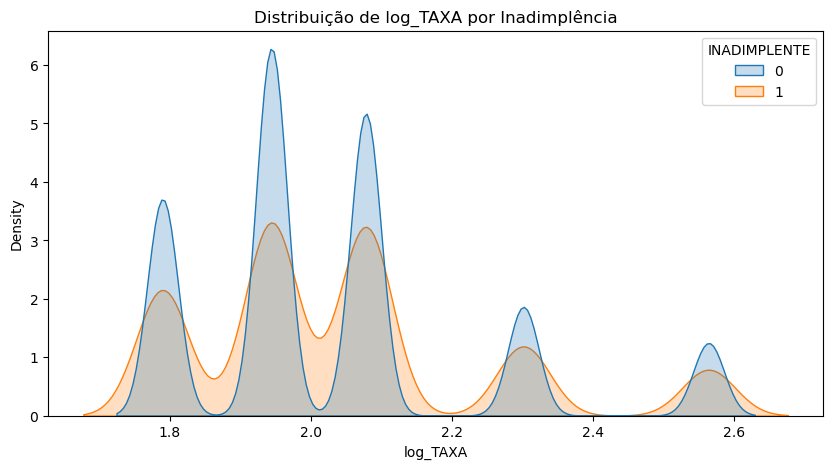

In [16]:
def plot_kde(df, col, log=False):
    """
    Gera um gr√°fico de Densidade de Kernel (KDE) para uma coluna espec√≠fica de um DataFrame,
    separando as distribui√ß√µes pela coluna 'INADIMPLENTE'.

    Par√¢metros:
        df (pd.DataFrame): O DataFrame contendo os dados.
        col (str): O nome da coluna num√©rica a ser plotada.
        log (bool, opcional): Se True, aplica uma transforma√ß√£o logar√≠tmica (log1p)
                             na coluna especificada antes de plotar..

    Retorna:
        None: Exibe o gr√°fico KDE diretamente.
    """

    plt.figure(figsize=(10, 5))
    # Aplica a transforma√ß√£o logar√≠tmica, se especificado
    if log:
        df = df[df[col] > 0].copy()
        df[f'log_{col}'] = np.log1p(df[col])
        col = f'log_{col}'
    
    # Gera o gr√°fico
    sns.kdeplot(data=df, x=col, hue='INADIMPLENTE', fill=True, common_norm=False)
    plt.title(f'Distribui√ß√£o de {col} por Inadimpl√™ncia')
    plt.show()

cols_num = ['VALOR_A_PAGAR', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'TAXA']
for col in cols_num:
    plot_kde(base_dev, col, log=True)

Observando os gr√°ficos, podemos perceber que:

- Cobran√ßas de menor valor parecem estar associadas a uma maior propens√£o √† inadimpl√™ncia. Isso pode indicar que clientes com menor comprometimento financeiro tendem a priorizar menos esses pagamentos, ou que tais cobran√ßas representam opera√ß√µes de menor valor e, possivelmente, com menor controle ou acompanhamento;

- A an√°lise da vari√°vel log_RENDA_MES_ANTERIOR sugere que n√≠veis mais baixos de renda est√£o associados a uma maior propor√ß√£o de inadimpl√™ncia. Esse comportamento √© coerente com a expectativa de que empresas ou indiv√≠duos com menor faturamento mensal enfrentem mais dificuldades para manter os pagamentos em dia;

- Empresas com menor n√∫mero de funcion√°rios apresentam uma leve tend√™ncia a maior inadimpl√™ncia. Embora a diferen√ßa entre os grupos seja menos acentuada do que em outras vari√°veis analisadas, essa caracter√≠stica ainda pode contribuir para a modelagem preditiva quando combinada com outras informa√ß√µes;

- Os clientes se distribuem em diferentes faixas de taxa (log_TAXA), com m√∫ltiplos picos de concentra√ß√£o. No entanto, ao compararmos os inadimplentes com os adimplentes, nota-se que h√° uma maior densidade relativa de inadimplentes em faixas de taxa mais elevadas. Isso sugere que valores mais altos de taxa est√£o potencialmente associados a um maior risco de inadimpl√™ncia, o que refor√ßa a relev√¢ncia da vari√°vel log_TAXA na determina√ß√£o de uma poss√≠vel inadimpl√™ncia;

Dado o comportamento observado nas distribui√ß√µes e a presen√ßa de assimetrias nas vari√°veis originais, optaremos por utilizar as vers√µes log-transformadas tamb√©m na modelagem preditiva, a fim de melhorar a performance dos algoritmos e a estabilidade das vari√°veis.

Quanto aos outliers, vamos agora observar o comportamento das vari√°veis num√©ricas por meio de boxplots, analisando a distribui√ß√£o dos dados brutos e a presen√ßa de valores extremos.

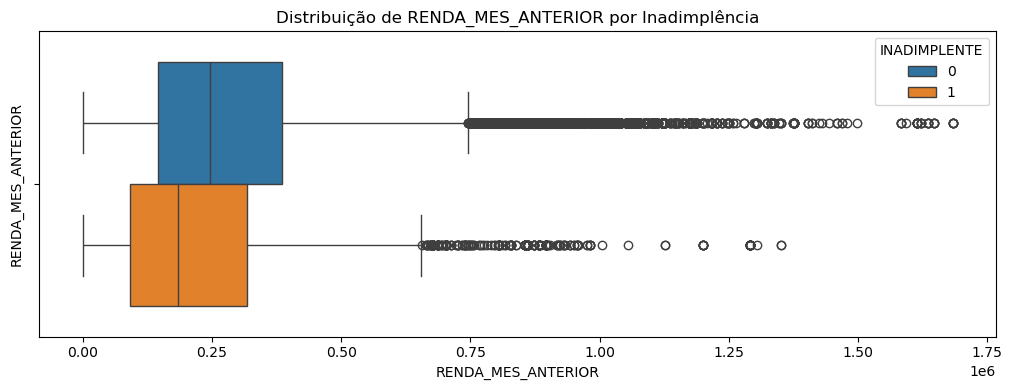

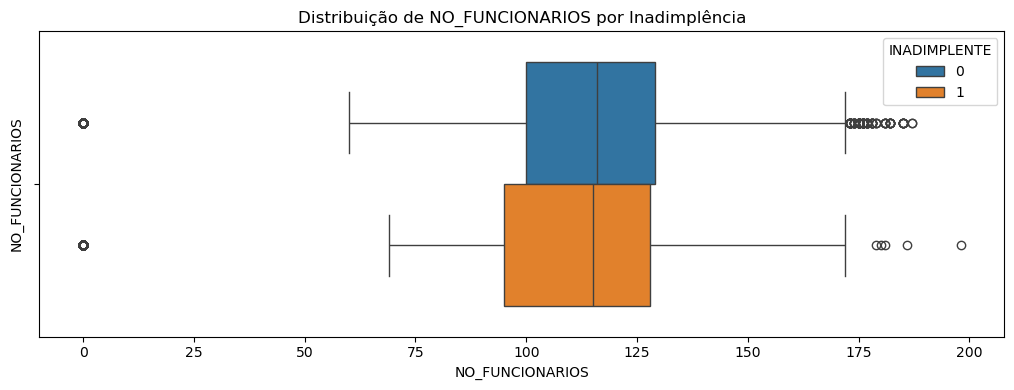

In [17]:
def plot_boxplot(df, col):
    """
    Gera um gr√°fico de caixa (Box Plot) para uma coluna num√©rica espec√≠fica de um DataFrame,
    separando as distribui√ß√µes pela coluna 'INADIMPLENTE'.

    Par√¢metros:
        df (pd.DataFrame): O DataFrame contendo os dados.
        col (str): O nome da coluna num√©rica a ser plotada.

    Retorna:
        None: Exibe o gr√°fico de caixa diretamente.
    """

    # gera√ß√£o do gr√°fico
    plt.figure(figsize=(10, 4))
    sns.boxplot(df, x=col, hue='INADIMPLENTE')
    plt.title(f'Distribui√ß√£o de {col} por Inadimpl√™ncia')
    plt.tight_layout()
    plt.ylabel(f'{col}')
    plt.show()

for col in ['VALOR_A_PAGAR', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'TAXA']:
    plot_boxplot(base_dev, col)

De forma geral, as distribui√ß√µes originais das vari√°veis num√©ricas analisadas apresentam forte assimetria positiva, com presen√ßa de valores extremos que dificultam a diferencia√ß√£o clara entre inadimplentes e adimplentes nas representa√ß√µes brutas. No entanto, as vers√µes log-transformadas dessas vari√°veis mostraram melhor desempenho na separa√ß√£o dos grupos, al√©m de maior estabilidade estat√≠stica. Esse comportamento refor√ßa a decis√£o de adotar as transforma√ß√µes logar√≠tmicas na modelagem preditiva, garantindo maior robustez e interpretabilidade dos resultados.

C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\1738844545.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby(col)['INADIMPLENTE'].mean().sort_values(ascending=False)


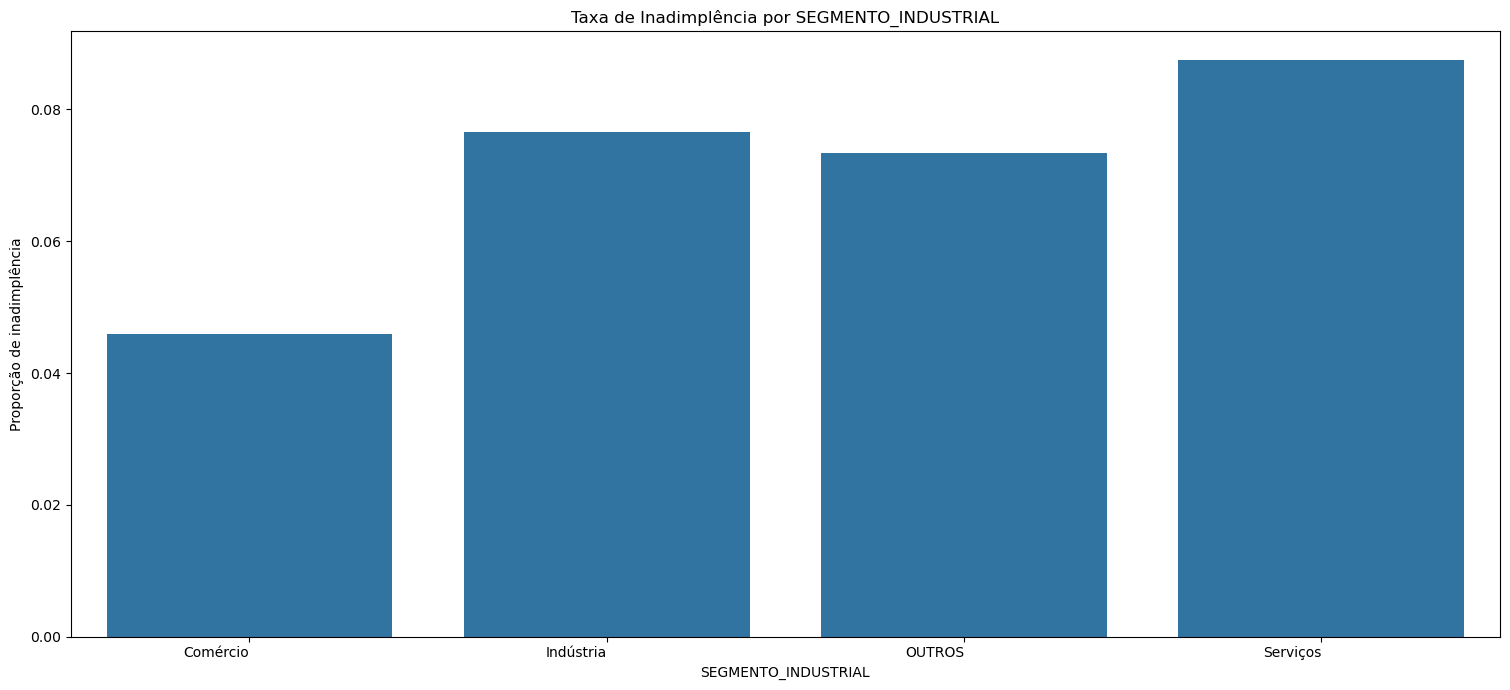

C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\1738844545.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby(col)['INADIMPLENTE'].mean().sort_values(ascending=False)


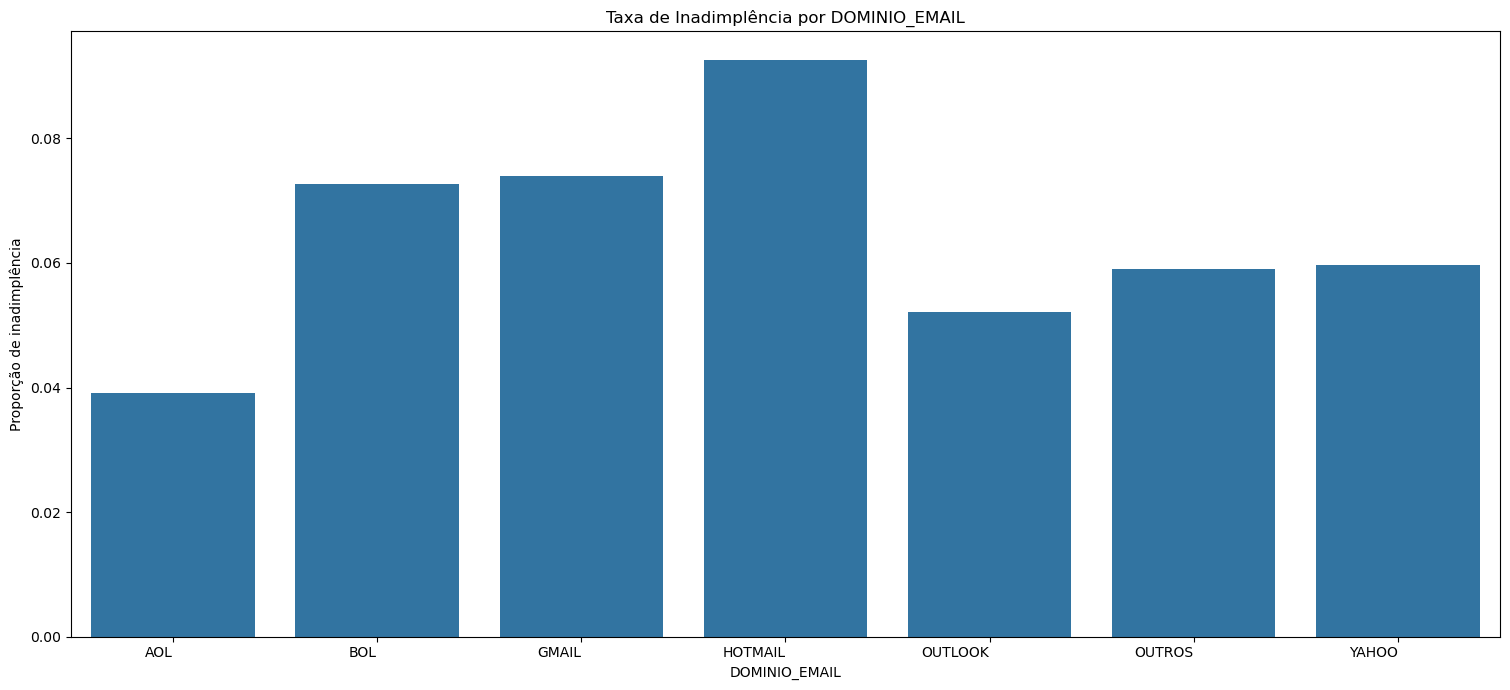

C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\1738844545.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby(col)['INADIMPLENTE'].mean().sort_values(ascending=False)


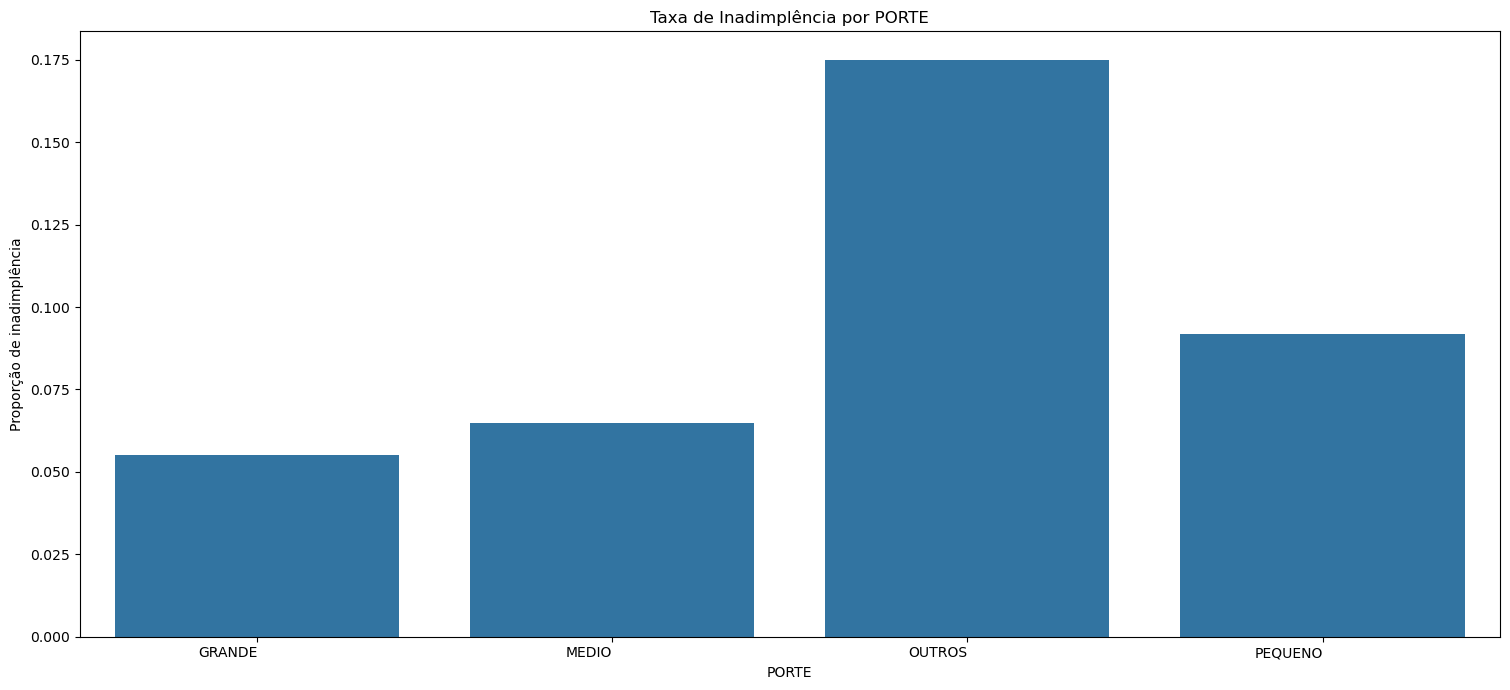

C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\1738844545.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby(col)['INADIMPLENTE'].mean().sort_values(ascending=False)


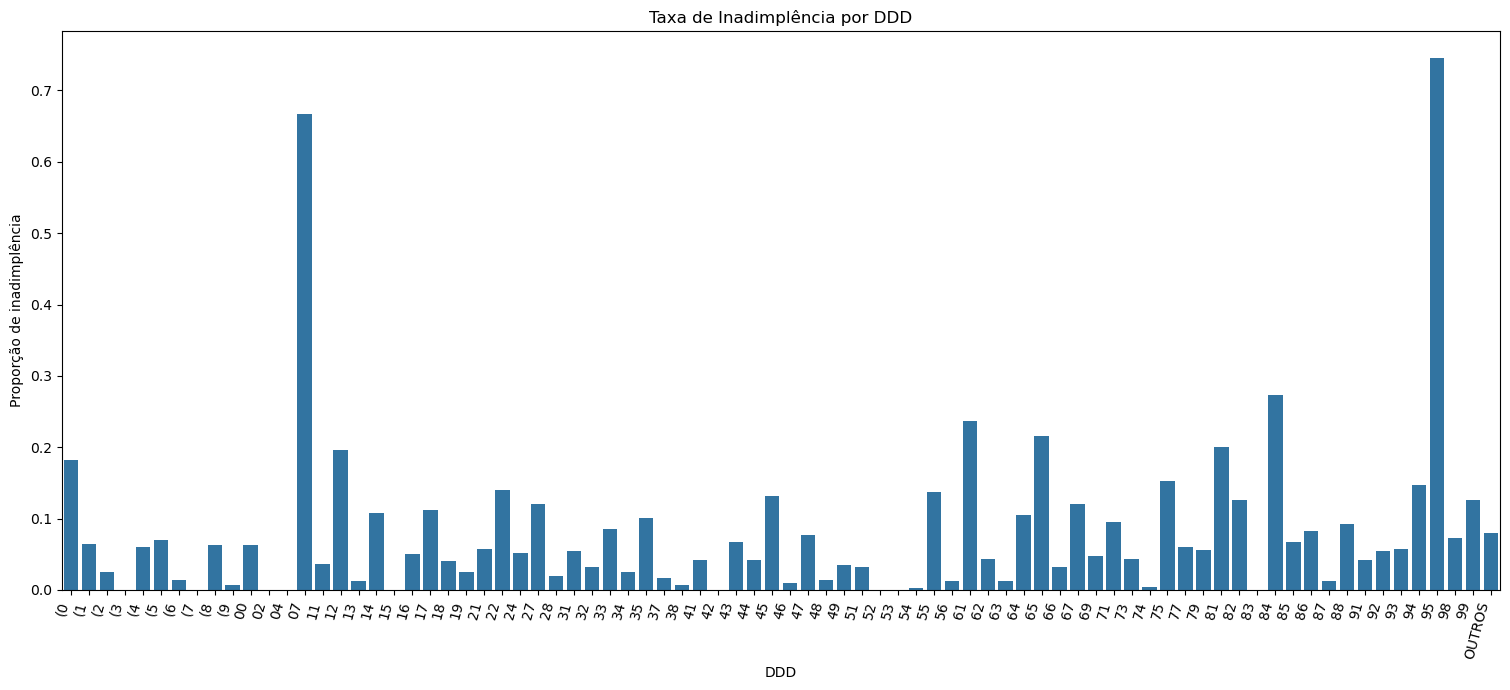

C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\1738844545.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby(col)['INADIMPLENTE'].mean().sort_values(ascending=False)


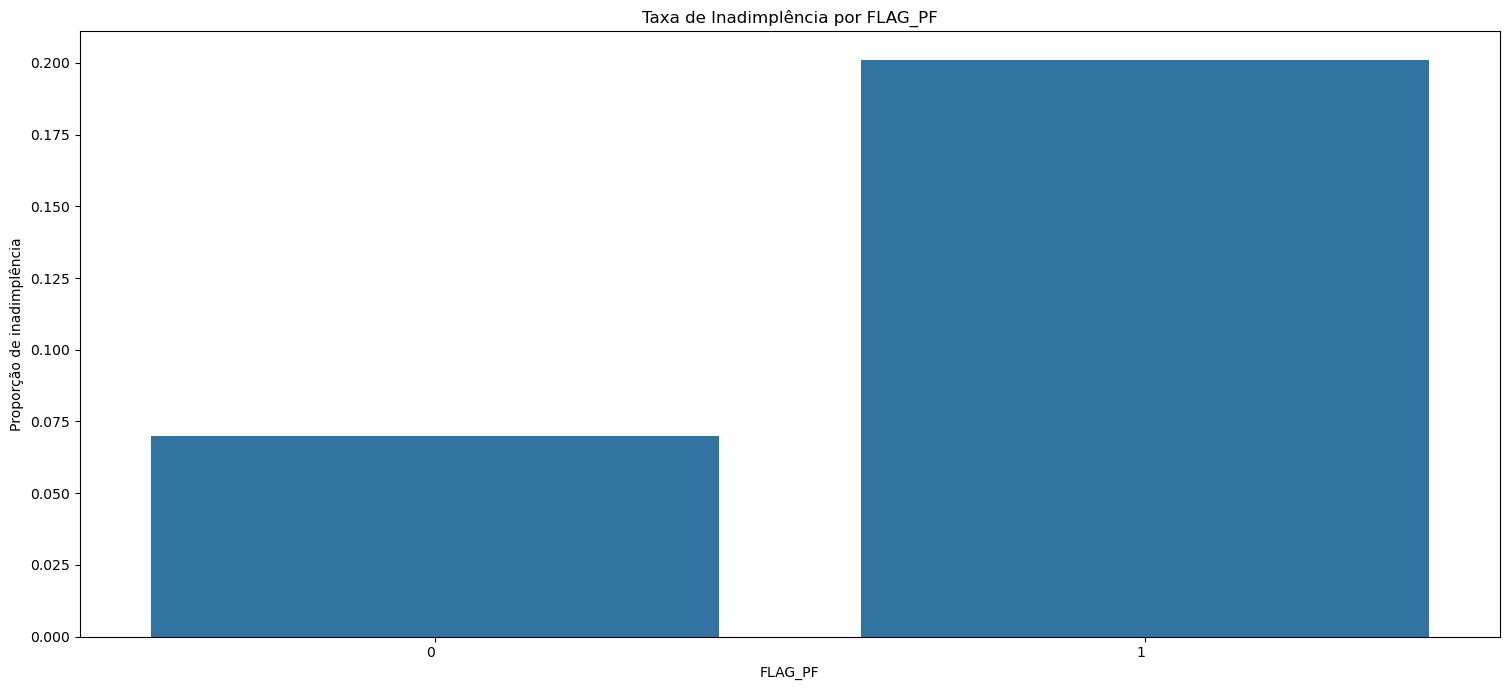

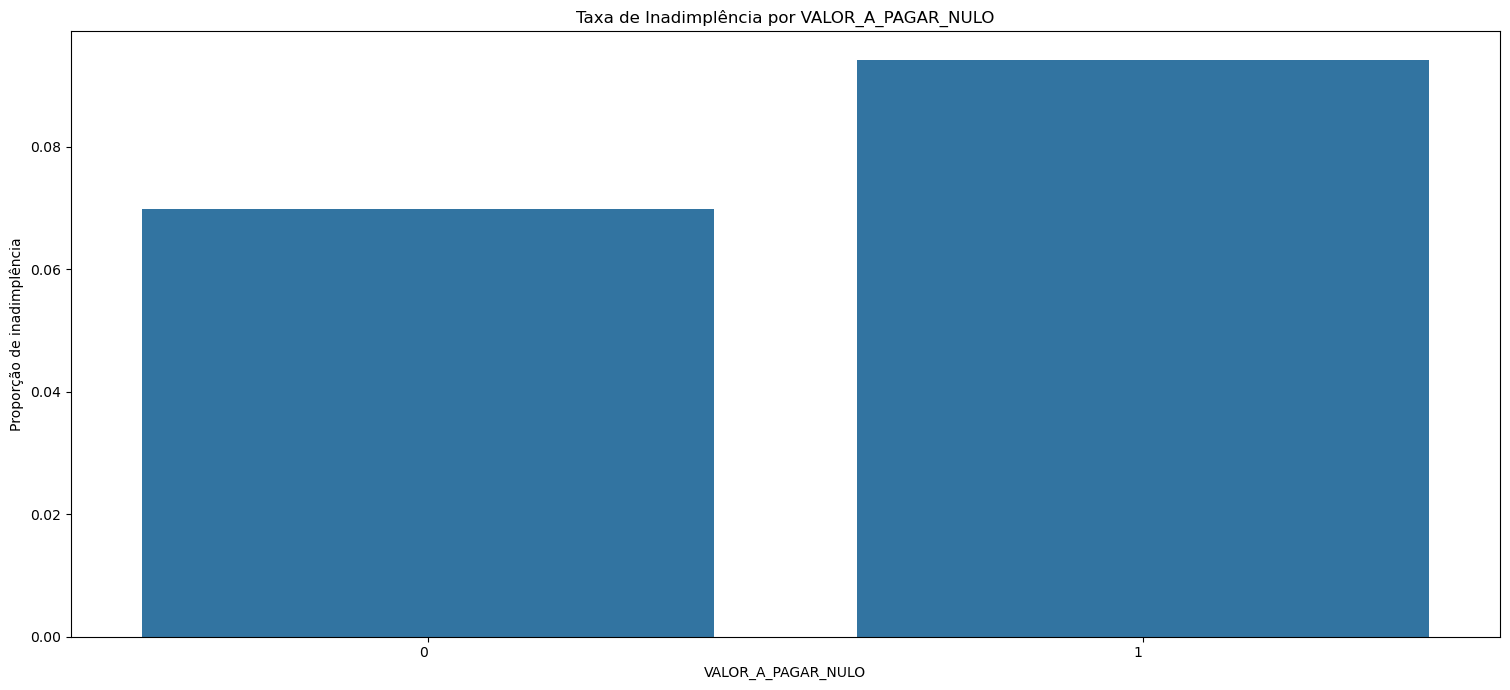

In [18]:
def plot_bar_categorical(df, col, rotation=0):
    """
    Gera um gr√°fico de barras mostrando a taxa de inadimpl√™ncia para cada categoria
    em uma coluna categ√≥rica de um DataFrame.

    Par√¢metros:
        df (pd.DataFrame): O DataFrame contendo os dados.
        col (str): O nome da coluna categ√≥rica a ser plotada.
        rotation (int, opcional): Rota√ß√£o dos r√≥tulos do eixo x em graus.
                                   Defaults to 0.

    Retorna:
        None: Exibe o gr√°fico de barras diretamente.
    """

    # Calcula a taxa de inadimpl√™ncia para cada categoria na coluna especificada
    # Agrupa o DataFrame pela coluna 'col' e calcula a m√©dia de 'INADIMPLENTE'
    # Ordena os resultados em ordem decrescente da taxa de inadimpl√™ncia
    temp = df.groupby(col)['INADIMPLENTE'].mean().sort_values(ascending=False)

    # gera o gr√°fico
    plt.figure(figsize=(15, 7))
    sns.barplot(x=temp.index, y=temp.values)
    plt.title(f'Taxa de Inadimpl√™ncia por {col}')
    plt.xticks(rotation=rotation, ha='right')
    plt.tight_layout()
    plt.ylabel('Propor√ß√£o de inadimpl√™ncia')
    plt.show()

cols_cat = ['SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'PORTE', 'DDD', 'CEP_2_DIG', 'FLAG_PF', 'VALOR_A_PAGAR_NULO', 'RENDA_MES_ANTERIOR_NULO', 'NO_FUNCIONARIOS_NULO']
for col in cols_cat:
    if col in ['DDD', 'CEP_2_DIG']:
        plot_bar_categorical(base_dev, col, rotation=75)
    else:
        plot_bar_categorical(base_dev, col)

Observando os gr√°ficos acima podemos notar que:

- O setor de **Servi√ßos** apresenta a maior taxa de inadimpl√™ncia, seguido pelos setores de **Ind√∫stria** e **Outros**. J√° o **Com√©rcio** se destaca por ter a menor taxa de inadimpl√™ncia entre os segmentos analisados;

- Dom√≠nios como **Hotmail** e **Gmail** apresentam taxas de inadimpl√™ncia acima da m√©dia. Esses padr√µes podem refletir perfis espec√≠ficos de clientes ‚Äî como idade, familiaridade digital ou canal de aquisi√ß√£o ‚Äî e, por isso, devem ser considerados com cautela, pois podem atuar como proxies indiretos de comportamento de risco;

- Empresas de **grande e m√©dio porte** apresentam as menores taxas de inadimpl√™ncia, enquanto aquelas classificadas como **pequeno porte** ou **outros** concentram os maiores √≠ndices. Isso sugere uma poss√≠vel associa√ß√£o entre o porte da empresa e o risco de cr√©dito, indicando que empresas menores ou mal categorizadas podem representar maior propens√£o √† inadimpl√™ncia. A elevada taxa no grupo **OUTROS** pode refletir falhas de categoriza√ß√£o, registros incompletos ou perfis at√≠picos de clientes, merecendo aten√ß√£o especial em processos de segmenta√ß√£o e an√°lise de risco;

- Embora alguns **DDDs** e **CEPs** apresentem taxas de inadimpl√™ncia extremamente altas, √© importante considerar que esses picos podem ser reflexo de grupos com baixa representatividade. Isso reduz a confiabilidade estat√≠stica dessas propor√ß√µes e refor√ßa a import√¢ncia de analisar os dados em conjunto com o volume de observa√ß√µes por grupo;

- A taxa de inadimpl√™ncia entre **pessoas f√≠sicas (PF)** √© significativamente maior do que entre **pessoas jur√≠dicas (PJ)**. Esse resultado sugere que clientes do tipo PF est√£o associados a um risco de cr√©dito mais elevado, sendo um fator relevante a ser considerado;

- Embora a diferen√ßa nas taxas de inadimpl√™ncia entre registros com e sem dados ausentes n√£o seja t√£o expressiva, observa-se um padr√£o consistente: a aus√™ncia de informa√ß√µes relevantes ‚Äî como **valor a pagar, renda do m√™s anterior** e **n√∫mero de funcion√°rios** ‚Äî est√° associada a uma inadimpl√™ncia ligeiramente maior. Esse comportamento sugere que a falta desses dados pode n√£o ser aleat√≥ria e pode estar correlacionada a perfis de maior risco, o que levanta um alerta importante quanto √† qualidade e completude das informa√ß√µes utilizadas na an√°lise;

Diante disso, para os dados de **CEP** e **DDD**, √© pertinente aprofundar a an√°lise a fim de entender melhor sua rela√ß√£o com a inadimpl√™ncia e verificar as propor√ß√µes de cada grupo, buscando identificar uma poss√≠vel regionaliza√ß√£o do risco de cr√©dito.

In [19]:
# visualiza√ß√£o da propor√ß√£o de inadimpl√™ncia pelo volume de dados para vari√°vel DDD

def plot_volume_por_inadimplencia(df, col):

    """
    Gera um gr√°fico de dispers√£o (Scatter Plot) mostrando a rela√ß√£o entre o volume
    de registros e a propor√ß√£o de inadimpl√™ncia para cada categoria em uma coluna espec√≠fica.

    Par√¢metros:
        df (pd.DataFrame): O DataFrame contendo os dados.
        var (str): O nome da coluna categ√≥rica a ser usada para agrupar os dados.

    Retorna:
        None: Exibe o gr√°fico de dispers√£o diretamente.
    """
    stats = base_dev.groupby(col).agg(
    inadimplencia=('INADIMPLENTE', 'mean'),
    volume=('INADIMPLENTE', 'count')
).reset_index()

    plt.figure(figsize=(10,6))
    sns.scatterplot(data=stats, x='volume', y='inadimplencia')
    plt.title(f"Inadimpl√™ncia vs Volume de Dados por {col}")
    plt.xlabel(f"Volume de registros por {col}")
    plt.ylabel("Propor√ß√£o de inadimpl√™ncia")
    plt.show()

for col in ['DDD', 'CEP_2_DIG']:
    plot_volume_por_inadimplencia(base_dev, col)

C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\2646306666.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = base_dev.groupby(col).agg(


C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\2646306666.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = base_dev.groupby(col).agg(


A an√°lise de dispers√£o entre a inadimpl√™ncia e o volume de registros por DDD e por os dois primeiros d√≠gitos do CEP refor√ßa a hip√≥tese de que muitas das taxas elevadas observadas em determinados grupos s√£o influenciadas por baixa representatividade amostral. Em ambos os gr√°ficos, √© poss√≠vel observar uma concentra√ß√£o de pontos com alta inadimpl√™ncia nos extremos de menor volume, indicando que esses valores podem ser estatisticamente inst√°veis. Isso evidencia a import√¢ncia de ponderar as an√°lises por volume de dados, evitando conclus√µes precipitadas com base em propor√ß√µes distorcidas por pequenos grupos.

Ap√≥s a an√°lise das vari√°veis num√©ricas e a confirma√ß√£o da import√¢ncia das transforma√ß√µes para lidar com assimetrias e outliers, √© importante agora investigar como o comportamento da inadimpl√™ncia evolui ao longo do tempo.

Para isso, utilizaremos a vari√°vel `SAFRA_REF` ‚Äî que representa a refer√™ncia temporal dos contratos ‚Äî a fim de identificar **padr√µes sazonais, tend√™ncias ou varia√ß√µes pontuais na taxa de inadimpl√™ncia**. Essa an√°lise pode revelar per√≠odos cr√≠ticos e apoiar estrat√©gias preditivas mais sens√≠veis √† dimens√£o temporal.

In [20]:
# calulando taxa e volume de inadimpl√™ncia por per√≠odo
inad_count = base_dev.groupby('SAFRA_REF').agg(
    inadimplencia=('INADIMPLENTE', 'mean'),
    volume=('INADIMPLENTE', 'count')
).reset_index()

# gerando gr√°fico para visualizar a taxa de inadimpl√™ncia ao longo do tempo
fig, ax1 = plt.subplots(figsize=(12,5))

ax2 = ax1.twinx()
ax1.plot(inad_count['SAFRA_REF'], inad_count['inadimplencia'], color='blue', marker='o', label='Inadimpl√™ncia')
ax2.bar(inad_count['SAFRA_REF'], inad_count['volume'], color='gray', alpha=0.3, label='Volume')

ax1.set_ylabel('Taxa de Inadimpl√™ncia')
ax2.set_ylabel('Volume de Contratos')
ax1.set_xlabel('Safra')
ax1.set_title('Inadimpl√™ncia e Volume de Contratos por Safra')
ax1.tick_params(axis='x', rotation=45)
fig.tight_layout()
plt.show()

A an√°lise da inadimpl√™ncia ao longo do tempo revela uma **tend√™ncia geral de estabilidade** na taxa de inadimpl√™ncia entre 2018 e 2021. A maioria das safras apresenta taxas entre 5% e 8%, com **flutua√ß√µes relativamente discretas**.

Entretanto, observamos um **pico acentuado no in√≠cio de 2020**, atingindo uma inadimpl√™ncia superior a 16%. Esse comportamento coincide com o in√≠cio da pandemia de COVID-19 no Brasil, indicando um poss√≠vel **impacto externo abrupto** sobre a capacidade de pagamento dos clientes. Ap√≥s esse per√≠odo, nota-se uma **r√°pida queda e posterior retorno √† normalidade** nas taxas de inadimpl√™ncia.

Do ponto de vista anal√≠tico, esse comportamento refor√ßa:

- A **import√¢ncia de considerar o fator temporal** na modelagem, principalmente para identificar per√≠odos at√≠picos.

- A necessidade de aten√ß√£o a **eventuais efeitos sazonais ou externos**, como crises econ√¥micas ou mudan√ßas regulat√≥rias.

Al√©m da data de refer√™ncia da cobran√ßa (`SAFRA_REF`), o dataset tamb√©m apresenta as datas de vencimento de cada t√≠tulo. Avaliar a diferen√ßa entre a safra e o vencimento pode fornecer ind√≠cios importantes sobre o prazo concedido para pagamento, o que pode impactar diretamente o risco de inadimpl√™ncia.

A vari√°vel `DEFASAGEM_SAFRA_VENCIMENTO`, calculada como o n√∫mero de meses entre a data de refer√™ncia da cobran√ßa e o vencimento da fatura, foi criada para investigar essa rela√ß√£o.

A seguir, analisamos a distribui√ß√£o dessa defasagem e a taxa de inadimpl√™ncia m√©dia por faixa de prazo.

In [21]:
# c√°lculo da defasagem entre 
def diff_meses(data1, data2):
    """
    Calcula a diferen√ßa em meses entre duas datas.

    Par√¢metros:
        data1 (datetime.date): A data inicial.
        data2 (datetime.date): A data final.

    Retorna:
        int: A diferen√ßa em meses entre data2 e data1.
             Um valor positivo se data2 for posterior a data1.
             Um valor negativo se data2 for anterior a data1.
             Zero se as datas forem iguais.
    """
    return (data2.year - data1.year) * 12 + data2.month - data1.month

base_dev['DEFASAGEM_SAFRA_VENCIMENTO'] = base_dev.apply(lambda x: diff_meses(x['SAFRA_REF'], x['DATA_VENCIMENTO']), axis=1)

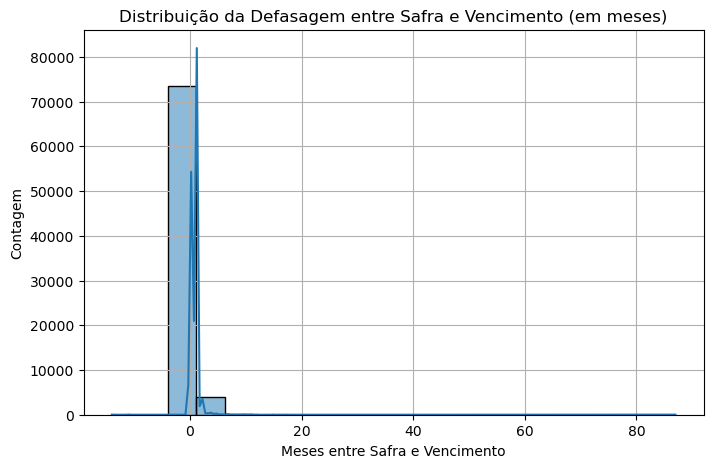

In [22]:
# visualiza√ß√£o da distribui√ß√£o da diferen√ßa entre SAFRA e vencimento
plt.figure(figsize=(8,5))
sns.histplot(base_dev['DEFASAGEM_SAFRA_VENCIMENTO'], bins=20, kde=True)
plt.title('Distribui√ß√£o da Defasagem entre Safra e Vencimento (em meses)')
plt.xlabel('Meses entre Safra e Vencimento')
plt.ylabel('Contagem')
plt.grid(True)
plt.show()

In [23]:
# visualiza√ß√£o da taxa de inadimpl√™ncia conforme aumenta o prazo de vencimento
inad_per_defasagem = base_dev.groupby('DEFASAGEM_SAFRA_VENCIMENTO')['INADIMPLENTE'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=inad_per_defasagem, x='DEFASAGEM_SAFRA_VENCIMENTO', hue='INADIMPLENTE', palette='viridis')
plt.title('Taxa de Inadimpl√™ncia por Defasagem entre Safra e Vencimento')
plt.xlabel('Meses entre Safra e Vencimento')
plt.ylabel('Taxa de Inadimpl√™ncia')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [24]:
# Visualiza√ß√£o da defasagem por inadimpl√™ncia

plt.figure(figsize=(8,5))
sns.boxplot(data=base_dev, x='INADIMPLENTE', y='DEFASAGEM_SAFRA_VENCIMENTO')
plt.title('Distribui√ß√£o da Defasagem por Status de Inadimpl√™ncia')
plt.xlabel('Inadimplente (0 = N√£o, 1 = Sim)')
plt.ylabel('Meses entre Safra e Vencimento')
plt.grid(True)
plt.show()

Observando o comportamento dos dados, podemos observar que:

- A defasagem entre a data de refer√™ncia da cobran√ßa (SAFRA_REF) e a data de vencimento apresenta forte concentra√ß√£o entre 0 e 6 meses, com poucos casos extremos (outliers) de vencimento muito postergado. Isso sugere que a maior parte das cobran√ßas √© gerada com vencimentos pr√≥ximos √† sua refer√™ncia, com alguns casos fora do padr√£o que podem demandar aten√ß√£o;

- H√° um aparente aumento na taxa de inadimpl√™ncia √† medida que a defasagem entre safra e vencimento aumenta, especialmente a partir de 5 meses. Esse comportamento pode refletir maior risco associado a cobran√ßas com vencimentos mais distantes da safra, sendo uma vari√°vel importante para o modelo de previs√£o;

- O boxplot refor√ßa a tend√™ncia observada anteriormente: inadimplentes tendem a apresentar uma leve defasagem maior em rela√ß√£o aos adimplentes. Apesar da mediana ser pr√≥xima, a dispers√£o √© maior no grupo inadimplente, com presen√ßa de outliers relevantes;

Ap√≥s analisar a defasagem entre a data de refer√™ncia da cobran√ßa `(SAFRA_REF)` e a data de vencimento, prosseguimos agora com a investiga√ß√£o da diferen√ßa entre a **data de emiss√£o do documento** `(DATA_EMISSAO_DOCUMENTO)` e a **data de pagamento** `(DATA_PAGAMENTO)`.

Essa defasagem pode indicar o comportamento do cliente em rela√ß√£o ao tempo que leva para realizar o pagamento ap√≥s a gera√ß√£o da cobran√ßa, e pode estar associada √† inadimpl√™ncia, especialmente em clientes que costumam postergar seus pagamentos.

A seguir, exploramos a distribui√ß√£o desse intervalo, bem como sua rela√ß√£o com a inadimpl√™ncia, por meio de histogramas, boxplots e an√°lise de taxa de inadimpl√™ncia por faixas de tempo.

In [25]:
# Visualiza√ß√£o da distribui√ß√£o da defasagem entre emiss√£o e pagamento (em dias)
base_dev['EMISSAO_PAGAMENTO_DIAS'] = (base_dev['DATA_PAGAMENTO'] - base_dev['DATA_EMISSAO_DOCUMENTO']).dt.days
sns.histplot(base_dev['EMISSAO_PAGAMENTO_DIAS'], bins=50, kde=True)
plt.title('Distribui√ß√£o da Defasagem entre Emiss√£o e Pagamento (em dias)')
plt.xlabel('Dias entre Emiss√£o e Pagamento')
plt.ylabel('Contagem')

Text(0, 0.5, 'Contagem')

C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\519662271.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  taxa_inad = base_dev.groupby('BUCKET_EMISSAO_PAGAMENTO')['INADIMPLENTE'].mean().reset_index()


Text(0.5, 1.0, 'Taxa de Inadimpl√™ncia por Intervalo entre Emiss√£o e Pagamento')

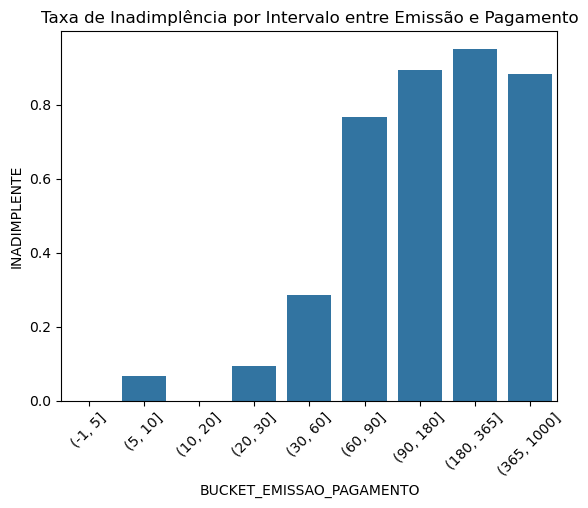

In [26]:
# Visualiza√ß√£o da taxa de inadimpl√™ncia por intervalo de tempo entre emiss√£o e pagamento
base_dev['BUCKET_EMISSAO_PAGAMENTO'] = pd.cut(base_dev['EMISSAO_PAGAMENTO_DIAS'], bins=[-1, 5, 10, 20, 30, 60, 90, 180, 365, 1000])
taxa_inad = base_dev.groupby('BUCKET_EMISSAO_PAGAMENTO')['INADIMPLENTE'].mean().reset_index()
sns.barplot(data=taxa_inad, x='BUCKET_EMISSAO_PAGAMENTO', y='INADIMPLENTE')
plt.xticks(rotation=45)
plt.title('Taxa de Inadimpl√™ncia por Intervalo entre Emiss√£o e Pagamento')

Text(0.5, 1.0, 'Distribui√ß√£o de Dias entre Emiss√£o e Pagamento por Status de Inadimpl√™ncia')

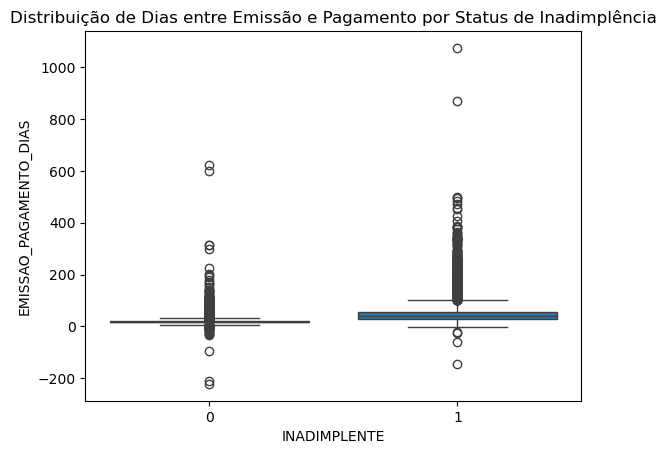

In [27]:
# Visualiza√ß√£o da distribui√ß√£o de dias entre emiss√£o e pagamento por inadimpl√™ncia
sns.boxplot(x='INADIMPLENTE', y='EMISSAO_PAGAMENTO_DIAS', data=base_dev)
plt.title('Distribui√ß√£o de Dias entre Emiss√£o e Pagamento por Status de Inadimpl√™ncia')

Podemos observar que:

- A maioria dos pagamentos ocorre em um intervalo relativamente curto ap√≥s a emiss√£o do documento. No entanto, h√° casos extremos de longos atrasos, que merecem aten√ß√£o por possivelmente estarem associados √† inadimpl√™ncia;

- Existe uma forte correla√ß√£o positiva entre o n√∫mero de dias entre emiss√£o e pagamento e a inadimpl√™ncia. Quanto maior esse intervalo, maior a chance de inadimpl√™ncia;

- Clientes inadimplentes, em m√©dia, demoram significativamente mais para realizar o pagamento ap√≥s a emiss√£o. A presen√ßa de outliers nesse grupo sugere que alguns casos extremos podem estar influenciando negativamente o padr√£o geral de pagamento;

- Existem alguns casos extremos com diferen√ßa negativa entre a data de emiss√£o do documento e a data de pagamento, inclusive entre clientes inadimplentes. Embora esse comportamento pare√ßa contradit√≥rio, ele pode refletir particularidades do processo, como emiss√£o retroativa ap√≥s a confirma√ß√£o de pagamento. Al√©m disso, foi identificado um caso de inadimpl√™ncia com diferen√ßa positiva de mais de 1000 dias entre emiss√£o e pagamento, valor que tamb√©m foge completamente do padr√£o observado e n√£o se encaixa em nenhum intervalo da vari√°vel categ√≥rica BUCKET_EMISSAO_PAGAMENTO, indicando uma poss√≠vel inconsist√™ncia ou situa√ß√£o at√≠pica;
---
üí° Importante: Apesar da forte rela√ß√£o com inadimpl√™ncia, todas as vari√°veis derivadas da data de pagamento foram utilizadas apenas para fins explorat√≥rios e n√£o ser√£o inclu√≠das na modelagem preditiva, uma vez que as informa√ß√µes de pagamento n√£o est√£o dispon√≠veis no conjunto de teste. Essa decis√£o visa garantir a validade do modelo em cen√°rios reais de previs√£o, evitando o uso de informa√ß√µes n√£o dispon√≠veis no momento da decis√£o.

Outro ponto relevante que pode impactar a modelagem preditiva ‚Äî especialmente em modelos lineares, como a Regress√£o Log√≠stica ‚Äî √© a presen√ßa de multicolinearidade entre vari√°veis independentes. Para investigar esse aspecto, ser√° realizada uma an√°lise de correla√ß√£o entre as vari√°veis num√©ricas, a fim de identificar rela√ß√µes redundantes que possam comprometer a estabilidade e interpretabilidade do modelo.

In [28]:
# visuzlia√ß√£o da correla√ß√£o entre as vari√°veis num√©ricas
num_cols = ['VALOR_A_PAGAR', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'TAXA']
corr_matrix = base_dev[num_cols].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Matriz de Correla√ß√£o entre Vari√°veis Num√©ricas")
plt.show()

A an√°lise da matriz de correla√ß√£o entre as vari√°veis num√©ricas revela n√≠veis bastante baixos de associa√ß√£o linear entre os atributos considerados. Isso indica uma baixa presen√ßa de multicolinearidade, o que √© positivo para a constru√ß√£o dos modelos preditivos ‚Äî especialmente para a Regress√£o Log√≠stica, que pode ser sens√≠vel a esse tipo de redund√¢ncia entre vari√°veis. Com isso, n√£o √© necess√°ria, neste momento, a elimina√ß√£o de vari√°veis com base nesse crit√©rio.

## 3 - Modelagem

Com base na an√°lise explorat√≥ria dos dados (EDA), foi poss√≠vel identificar padr√µes relevantes associados √† inadimpl√™ncia, como o impacto da taxa de cobran√ßa (TAXA), o comportamento de vari√°veis ao longo do tempo, e a aus√™ncia de problemas significativos de multicolinearidade entre os atributos num√©ricos. Essas observa√ß√µes fornecem uma base s√≥lida para avan√ßarmos √† etapa de modelagem preditiva.

O objetivo agora √© construir modelos capazes de estimar a probabilidade de inadimpl√™ncia de cobran√ßas futuras, com base nos registros dispon√≠veis. Para isso, o processo de modelagem ser√° estruturado em etapas bem definidas, visando tanto a robustez preditiva quanto a interpretabilidade dos resultados para suporte √† tomada de decis√£o.

### Etapas da Modelagem
1. **Pr√©-processamento e Engenharia de Atributos**
    - Nesta etapa, ser√£o criadas vari√°veis transformadas, como os logaritmos das vari√°veis num√©ricas, e realizados os ajustes finais nos dados para garantir compatibilidade com os algoritmos de machine learning.

2. **Modelagem e Busca de Hiperpar√¢metros**
    - Tr√™s modelos ser√£o considerados: Regress√£o Log√≠stica (como benchmark), LightGBM e CatBoost. A busca pelos melhores hiperpar√¢metros ser√° conduzida via RandomizedSearchCV, otimizando o desempenho preditivo com base nas m√©tricas escolhidas.

3. **Avalia√ß√£o e Interpreta√ß√£o dos Modelos**
    - Os modelos ser√£o avaliados por meio de m√©tricas que melhor capturam a natureza do problema. Como o objetivo √© **prever a probabilidade de inadimpl√™ncia**, com dados altamente desbalanceados, prioriza-se:

        - **AUC-ROC**: mede a capacidade do modelo em discriminar entre inadimplentes e adimplentes, independentemente do limiar de corte.

        - **Log Loss**: penaliza fortemente previs√µes mal calibradas, sendo ideal para avalia√ß√£o de modelos probabil√≠sticos.

    Al√©m da performance preditiva, tamb√©m ser√° avaliada a **import√¢ncia das vari√°veis**, para fins de gera√ß√£o de insights de neg√≥cio.

4. **Treinamento Final e Gera√ß√£o de Previs√µes**
    - O modelo selecionado ser√° treinado com todos os dados da base de desenvolvimento e, em seguida, utilizado para gerar as previs√µes de probabilidade de inadimpl√™ncia na base de teste.

### 2.1 - Pr√©-processamento

In [29]:
# defini√ß√£o das vari√°veis por tipo
cat_cols = ['SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 
            'PORTE', 'DDD', 'CEP_2_DIG', 
            'FLAG_PF', 'VALOR_A_PAGAR_NULO', 
            'RENDA_MES_ANTERIOR_NULO', 'NO_FUNCIONARIOS_NULO',
            ]

num_cols = ['VALOR_A_PAGAR', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'TAXA']
log_transform_cols = num_cols  # Todas as num√©ricas recebem log
drop_cols = ['VALOR_A_PAGAR', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'TAXA', 'ID_CLIENTE',
             'DATA_CADASTRO', 'DATA_VENCIMENTO', 'DATA_EMISSAO_DOCUMENTO']  

In [30]:
# cria√ß√£o de fun√ß√£o para pr√©-processamento dos dados
def preprocess_data(df, apply_cat_encoding=False):
    """
    Gera um dataset processado, adicionando informa√ß√µes sobre a transforma√ß√£o 
    logar√≠timica das vari√°veis num√©ricas, para suavizar efeitos de outliers,
    al√©m de codifica√ß√£o das vari√°veis categ√≥ricas quando pedido.

    Tamb√©m separa os dados em treino e valida√ß√£o para a etapa de modelagem.

    Par√¢metros:
        - df (pd.DataFrame): Dataframe contendo os dados.
        - apply_cat_enconding (bool): flag para identificar se haver√° transforma√ß√£o
            das vari√°veis categ√≥ricas.

    Retorna:
        - X_train (pd.DataFrame): Features de treino.
        - y_train (pd.Series): Alvo de treino.
        - X_test (pd.DataFrame): Features de teste (valida√ß√£o).
        - y_test (pd.Series): Alvo de teste (valida√ß√£o).
    """

    df = df.copy()

    # Adi√ß√£o das informa√ß√µes de ano e m√™s
    df['ANO'] = df['SAFRA_REF'].dt.year.astype('int64')
    df['MES'] = df['SAFRA_REF'].dt.month.astype('int64')

    df.drop('SAFRA_REF', axis=1, inplace=True)

    # Tratamento de vari√°veis num√©ricas: log(1 + x)
    for col in log_transform_cols:
        df[f'log_{col}'] = np.log1p(df[col])

    # Remo√ß√£o das vari√°veis originais num√©ricas (mant√©m s√≥ os log)
    df.drop(columns=drop_cols, inplace=True)

    # Codifica√ß√£o de vari√°veis categ√≥ricas se necess√°rio
    if apply_cat_encoding:
        df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # Separar X e y   
    X = df.drop(columns='INADIMPLENTE')
    y = df['INADIMPLENTE']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        random_state=42,
                                                        test_size=.2,
                                                        stratify=y)

    return X_train, X_test, y_train, y_test


Como os modelos LightGBM e CatBoost lidam nativamente com vari√°veis categ√≥ricas, o conjunto de treino/valida√ß√£o para esses modelos manter√° as categorias em seu formato original. Por outro lado, a Regress√£o Log√≠stica requer vari√°veis num√©ricas, ent√£o ser√° utilizado um dataset distinto, com as vari√°veis categ√≥ricas transformadas via one-hot encoding.

In [31]:
# gera√ß√£o dos dados de treino e valida√ß√£o para regress√£o log√≠stica
X_train_lr, X_valid_lr, y_train_lr, y_valid_lr = preprocess_data(base_dev, apply_cat_encoding=True)

# gera√ß√£o dos dados de treino e valida√ß√£o para LightGBM e CatBoost
X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = preprocess_data(base_dev)

# Remo√ß√£o das colunas com informa√ß√£o relacionadas √† data de pagamento
X_train_lr.drop(columns=['DATA_PAGAMENTO',
             'EMISSAO_PAGAMENTO_DIAS', 'BUCKET_EMISSAO_PAGAMENTO'], inplace=True)

X_train_cat.drop(columns=['DATA_PAGAMENTO',
             'EMISSAO_PAGAMENTO_DIAS', 'BUCKET_EMISSAO_PAGAMENTO'], inplace=True)

X_valid_lr.drop(columns=['DATA_PAGAMENTO',
             'EMISSAO_PAGAMENTO_DIAS', 'BUCKET_EMISSAO_PAGAMENTO'], inplace=True)

X_valid_cat.drop(columns=['DATA_PAGAMENTO',
             'EMISSAO_PAGAMENTO_DIAS', 'BUCKET_EMISSAO_PAGAMENTO'], inplace=True)

### 2.2- Treinamento, predi√ß√£o e avalia√ß√£o dos dados de treino e valida√ß√£o

In [32]:
# defini√ß√£o da fun√ß√£o para avalia√ß√£o dos modelos
def evaluate_model(model, X_test, y_test, name="Model"):
    """
    Avalia um modelo de classifica√ß√£o bin√°ria usando AUC-ROC e Log Loss.

    Par√¢metros:
        model: O modelo de classifica√ß√£o treinado a ser avaliado.
               Deve ter um m√©todo `predict_proba` que retorna probabilidades
               para a classe positiva (geralmente a segunda coluna).
        X_test: Os dados de teste (features).
        y_test: Os r√≥tulos verdadeiros para os dados de teste.
        name (str, optional): O nome do modelo para exibi√ß√£o na sa√≠da.
                              Padr√£o √© "Model".

    Retorna:
        tuple: Uma tupla contendo:
            - auc (float): O valor da m√©trica AUC-ROC do modelo.
            - logloss (float): O valor da m√©trica Log Loss do modelo.
    """
    # Prever as probabilidades para a classe positiva
    proba = model.predict_proba(X_test)[:, 1]

    # C√°lculp a m√©trica AUC-ROC
    auc = roc_auc_score(y_test, proba)

    # C√°lculo a m√©trica Log Loss
    logloss = log_loss(y_test, proba)

    print(f"{name}:\n  AUC-ROC: {auc:.4f}\n  Log Loss: {logloss:.4f}\n")
    return auc, logloss

Para avaliar a performance dos modelos preditivos, foram adotadas m√©tricas adequadas ao contexto do problema, levando em considera√ß√£o a natureza desbalanceada da vari√°vel alvo (INADIMPLENTE), onde apenas cerca de 7% dos registros representam inadimpl√™ncia.

As principais m√©tricas utilizadas s√£o:

- **AUC-ROC (√Årea sob a curva ROC)**: mede a capacidade do modelo em distinguir corretamente entre classes (inadimplente vs adimplente) em diferentes limiares de decis√£o. Por ser uma m√©trica independente do threshold, ela √© particularmente adequada em cen√°rios desbalanceados e permite comparar modelos de forma justa.

- **Log Loss (Logaritmic Loss)**: avalia a calibra√ß√£o das probabilidades previstas. Penaliza previs√µes com alta confian√ßa e incorretas. √â √∫til quando o objetivo √© prever a **probabilidade de inadimpl√™ncia**, e n√£o apenas classificar binariamente.

Essa dupla de m√©tricas permite capturar tanto a **discriminatividade** (via AUC) quanto a **confiabilidade probabil√≠stica** (via Log Loss) dos modelos.

Al√©m disso, para modelos que lidam com classifica√ß√µes desbalanceadas, foi adotado o uso de **pesos de classe**, atribuindo maior peso √† classe minorit√°ria (inadimplentes), de modo a reduzir o vi√©s do modelo em favor da classe majorit√°ria.

A fun√ß√£o de avalia√ß√£o personalizada foi constru√≠da para calcular essas m√©tricas de maneira uniforme para todos os modelos, promovendo uma compara√ß√£o clara e objetiva entre as abordagens testadas.

### 2.2.1 - Regress√£o Log√≠stica

In [33]:
# Pipeline para Regress√£o Log√≠stica
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', class_weight={0: 1, 1: 13}, random_state=42))
])

param_dist_lr = {
    'clf__C': [0.01, 0.1, 1]
}

search_lr = RandomizedSearchCV(pipe_lr, param_distributions=param_dist_lr,
                               n_iter=10, cv=3, scoring='roc_auc', random_state=42)
search_lr.fit(X_train_lr, y_train_lr)

# avalia√ß√£o em treino e valida√ß√£o
print('---------Regress√£o Log√≠stica---------')
print('\nMelhores hiperpar√¢metros:', search_lr.best_params_)
print('\nResultados em treino')
evaluate_model(search_lr.best_estimator_, X_train_lr, y_train_lr, "Logistic Regression")
print('\nResultados em valida√ß√£o')
evaluate_model(search_lr.best_estimator_, X_valid_lr, y_valid_lr, "Logistic Regression")

c:\Users\vinic\anaconda3\envs\case_ds\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


---------Regress√£o Log√≠stica---------

Melhores hiperpar√¢metros: {'clf__C': 0.01}

Resultados em treino
Logistic Regression:
  AUC-ROC: 0.8814
  Log Loss: 0.4300


Resultados em valida√ß√£o
Logistic Regression:
  AUC-ROC: 0.8755
  Log Loss: 0.4339



(0.8754810379966018, 0.4338577783912772)

### 2.2.2 - CatBoost

In [34]:
# CatBoost
cat_model = CatBoostClassifier(class_weights=[1, 13], random_state=42, cat_features=cat_cols,
                               verbose=0)

param_dist_cat = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 500],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}

search_cat = RandomizedSearchCV(
    cat_model,
    param_distributions=param_dist_cat,
    n_iter=10,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

search_cat.fit(X_train_cat, y_train_cat)

# avalia√ß√£o em treino e valida√ß√£o
print('---------CatBoost---------')
print('\nMelhores hiperpar√¢metros:', search_cat.best_params_)
print('\nResultados em treino')
evaluate_model(search_cat.best_estimator_, X_train_cat, y_train_cat, "CatBoost")
print('\nResultados em valida√ß√£o')
evaluate_model(search_cat.best_estimator_, X_valid_cat, y_valid_cat, "CastBoost")

---------CatBoost---------

Melhores hiperpar√¢metros: {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 500, 'depth': 8, 'border_count': 64}

Resultados em treino
CatBoost:
  AUC-ROC: 0.9816
  Log Loss: 0.1904


Resultados em valida√ß√£o
CastBoost:
  AUC-ROC: 0.9544
  Log Loss: 0.2155



(0.9543711416311338, 0.21552923864508397)

### 2.2.3 - LightGBM

In [35]:
# LightGBM
lgbm_model = LGBMClassifier(class_weight={0:1, 1:13}, random_state=42,
                               )

param_dist_lgbm = {
    'num_leaves': [20, 30, 50],
    'max_depth': [3, 5, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150]
}

search_lgbm = RandomizedSearchCV(
    lgbm_model,
    param_distributions=param_dist_lgbm,
    n_iter=10,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=1
)

search_lgbm.fit(X_train_cat, y_train_cat)

# avalia√ß√£o em treino e valida√ß√£o
print('---------LightGBM---------')
print('\nMelhores hiperpar√¢metros:', search_lgbm.best_params_)
print('\nResultados em treino')
evaluate_model(search_lgbm.best_estimator_, X_train_cat, y_train_cat, "LightGBM")
print('\nResultados em valida√ß√£o')
evaluate_model(search_lgbm.best_estimator_, X_valid_cat, y_valid_cat, "LightGBM")

[LightGBM] [Info] Number of positive: 2899, number of negative: 38387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 41286, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495399 -> initscore=-0.018404
[LightGBM] [Info] Start training from score -0.018404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2900, number of negative: 38387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_row_wise=true` to remove t

(0.9442669472993239, 0.2505362375530513)


### Comparativo entre Modelos

| Modelo                 | AUC-ROC (Treino) | Log Loss (Treino) | AUC-ROC (Valida√ß√£o) | Log Loss (Valida√ß√£o) |
|------------------------|------------------|--------------------|----------------------|------------------------|
| Regress√£o Log√≠stica    | 0.8814           | 0.4300             | 0.8755               | 0.4339                 |
| LightGBM               | 0.9762           | 0.2261             | 0.9443               | 0.2505                 |
| CatBoost               | 0.9816           | 0.1904             | **0.9544**           | **0.2155**             |

---

### Conclus√µes sobre os modelos

- O **CatBoost** apresentou o melhor desempenho, tanto em AUC-ROC quanto em Log Loss na valida√ß√£o, sendo o modelo mais eficaz para o problema.
- O **LightGBM** tamb√©m apresentou excelente performance, com resultados muito pr√≥ximos, sendo uma boa alternativa com menor tempo de treinamento.
- A **Regress√£o Log√≠stica** teve performance inferior, mas ainda satisfat√≥ria. Sua principal vantagem √© a interpretabilidade dos coeficientes, sendo √∫til como baseline ou ferramenta de apoio na an√°lise.

Com base nos resultados, o **modelo CatBoost ser√° adotado para a previs√£o da probabilidade de inadimpl√™ncia**, dado seu √≥timo desempenho em discrimina√ß√£o e calibra√ß√£o.

Ap√≥s o treinamento dos modelos preditivos, √© fundamental entender quais vari√°veis mais influenciam na previs√£o de inadimpl√™ncia. Essa an√°lise de import√¢ncia das vari√°veis (feature importance) tem dois objetivos principais:

1. **Interpreta√ß√£o do Modelo**: Identificar os principais fatores associados ao risco de inadimpl√™ncia, fornecendo maior transpar√™ncia ao processo de decis√£o automatizado.
2. **Gera√ß√£o de Insights de Neg√≥cio**: Compreender quais caracter√≠sticas dos clientes, cobran√ßas ou comportamento financeiro impactam mais no risco, permitindo a√ß√µes mais direcionadas na gest√£o de cr√©dito.

A seguir, analisamos as vari√°veis mais relevantes segundo o modelo **CatBoost**, que apresentou o melhor desempenho preditivo entre os modelos testados.

C:\Users\vinic\AppData\Local\Temp\ipykernel_18796\2801990163.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(20), x='Importance', y='Feature', palette='viridis')


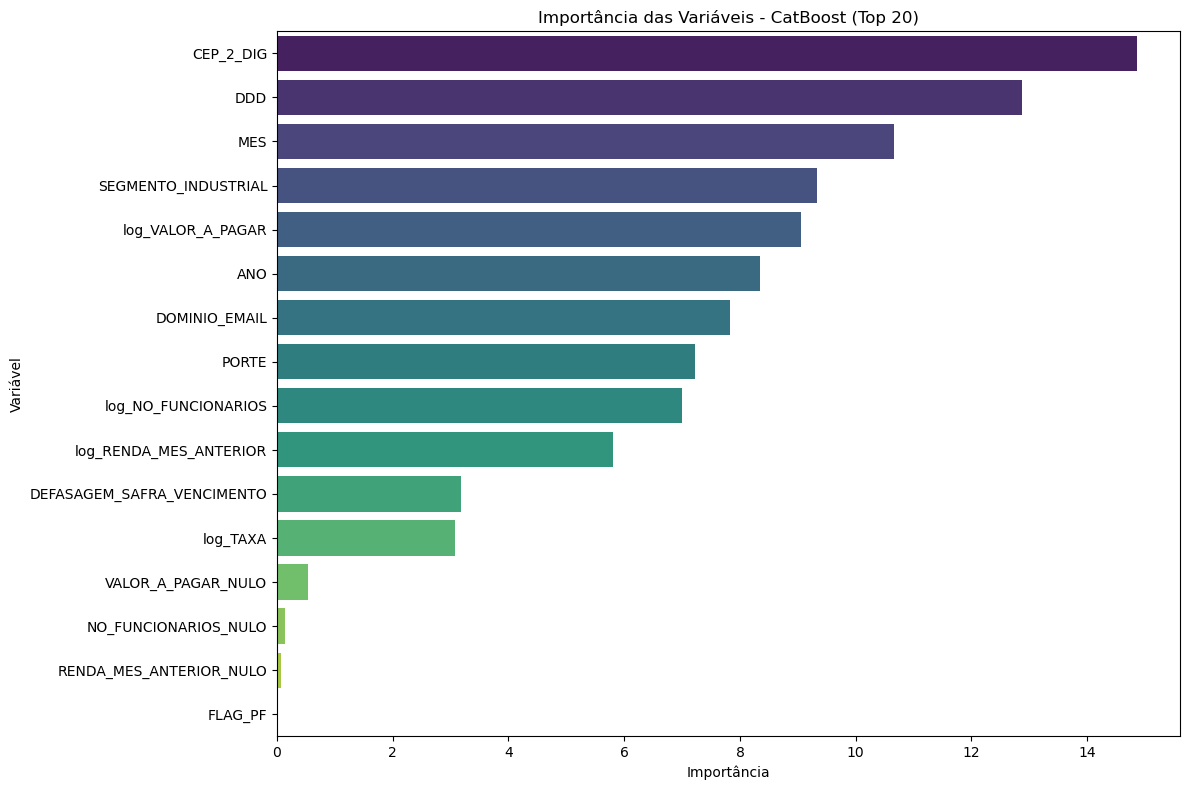

In [44]:
# Extra√ß√£o das informa√ß√µes de feature importance do modelo
cat_model = search_cat.best_estimator_
# Extrai os nomes das features e suas import√¢ncias
feature_importance = cat_model.get_feature_importance()
feature_names = X_train_cat.columns

# Cria um DataFrame ordenado
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Visualiza√ß√£o
plt.figure(figsize=(12, 8))
sns.barplot(data=feat_imp_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Import√¢ncia das Vari√°veis - CatBoost (Top 20)')
plt.xlabel('Import√¢ncia')
plt.ylabel('Vari√°vel')
plt.tight_layout()
plt.show()

A an√°lise de import√¢ncia das vari√°veis no modelo CatBoost revela os principais fatores associados √† inadimpl√™ncia. Os destaques s√£o:

- A vari√°vel `CEP_2_DIG` se destaca com a maior import√¢ncia no modelo. Isso sugere que a localiza√ß√£o geogr√°fica pode ter forte rela√ß√£o com o risco de inadimpl√™ncia, possivelmente refletindo desigualdades regionais ou caracter√≠sticas socioecon√¥micas.

- O `DDD` tamb√©m aparece como altamente relevante, refor√ßando a import√¢ncia da localiza√ß√£o, agora com base no c√≥digo de √°rea telef√¥nico.

- Vari√°veis temporais como `MES` e `ANO` tamb√©m figuram entre os principais preditores, indicando padr√µes sazonais ou varia√ß√µes no risco ao longo do tempo.

- A vari√°vel `log_VALOR_A_PAGAR` (valor do documento) mostra que o montante financeiro est√° relacionado ao risco, o que √© esperado ‚Äî valores mais altos podem estar associados a maior inadimpl√™ncia.

- Informa√ß√µes de **perfil empresarial**, como `PORTE`, `SEGMENTO_INDUSTRIAL`, `log_NO_FUNCIONARIOS`, e `log_RENDA_MES_ANTERIOR`, tamb√©m aparecem entre as vari√°veis mais importantes. Isso indica que aspectos estruturais da empresa influenciam o risco de inadimpl√™ncia.

- Vari√°veis como `DOMINIO_EMAIL` (dom√≠nio do e-mail usado) apresentaram relev√¢ncia intermedi√°ria. Isso pode refletir caracter√≠sticas de profissionalismo, uso de dom√≠nios gen√©ricos vs. corporativos, entre outros fatores.

- A vari√°vel `DEFASAGEM_SAFRA_VENCIMENTO`, relacionada a atrasos sazonais, apresentou menor, mas ainda significativa, import√¢ncia.

- Indicadores de valores ausentes, como `*_NULO`, e vari√°veis bin√°rias como `FLAG_PF` mostraram baixa contribui√ß√£o, o que √© positivo do ponto de vista de robustez e confiabilidade do modelo.

## 4 - Previs√£o Final e Gera√ß√£o do Entreg√°vel
Ap√≥s a an√°lise explorat√≥ria, engenharia de vari√°veis, tratamento de inconsist√™ncias e compara√ß√£o entre modelos, chegamos √† etapa final do projeto. Nesta fase, o objetivo √© treinar o modelo escolhido com todos os dados dispon√≠veis (exceto o conjunto de teste), aplicar os mesmos tratamentos ao conjunto de teste e, por fim, gerar as previs√µes a serem entregues.

A seguir, realizamos:

- Re-treinamento do modelo final com os dados completos;

- Processamento do conjunto de teste com os mesmos crit√©rios aplicados ao treino;

- Gera√ß√£o das probabilidades de inadimpl√™ncia;

- Montagem do arquivo final com as previs√µes.

In [37]:
# Jun√ß√£o dos dados de treino e valida√ß√£o

X_full = pd.concat([X_train_cat, X_valid_cat], axis=0)
y_full = pd.concat([y_train_cat, y_valid_cat], axis=0)

In [38]:
# treinamento do modelo final

final_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    border_count=64,
    l2_leaf_reg=5,
    class_weights={0: 1, 1: 13},
    random_state=42,
    verbose=0,
    cat_features=cat_cols
)

final_model.fit(X_full, y_full)

In [39]:
# visualiza√ß√£o das informa√ß√µes de teste
base_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12264 entries, 0 to 12263
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID_CLIENTE               12264 non-null  int64         
 1   SAFRA_REF                12264 non-null  datetime64[ns]
 2   DATA_EMISSAO_DOCUMENTO   12264 non-null  datetime64[ns]
 3   DATA_VENCIMENTO          12264 non-null  datetime64[ns]
 4   VALOR_A_PAGAR            12264 non-null  float64       
 5   TAXA                     12264 non-null  float64       
 6   VALOR_A_PAGAR_NULO       12264 non-null  int64         
 7   DATA_CADASTRO            12226 non-null  datetime64[ns]
 8   DDD                      12226 non-null  category      
 9   FLAG_PF                  12226 non-null  float64       
 10  SEGMENTO_INDUSTRIAL      12226 non-null  category      
 11  DOMINIO_EMAIL            12226 non-null  category      
 12  PORTE                    12226 n

Podemos observar que 38 registros apresentam valores ausentes nas seguintes vari√°veis categ√≥ricas: `DDD`, `FLAG_PF`, `SEGMENTO_INDUSTRIAL`, `DOMINIO_EMAIL`, `PORTE` e `CEP_2_DIG`.

Como essas vari√°veis foram relevantes no modelo e os dados de teste n√£o podem ser descartados, optamos por substituir os valores nulos por uma categoria expl√≠cita `"NULO"`. Apesar de essa categoria n√£o ter aparecido na base de treino, o CatBoost lida corretamente com categorias in√©ditas durante a infer√™ncia, utilizando estimativas regularizadas para gerar previs√µes consistentes.

Essa abordagem garante integridade nos dados e compatibilidade com o modelo, sem comprometer a performance ou a interpretabilidade.


In [40]:
# Separa√ß√£o dos IDs dos clientes para adi√ß√£o √† informa√ß√£o final das predi√ß√µes

ids = base_teste['ID_CLIENTE']

# Separa√ß√£o da SAFRA_REF para adi√ß√£o √† informa√ß√£o final das predi√ß√µes

safra_ref = base_teste['SAFRA_REF']

In [41]:
# pr√©-processamento do conjunto de teste

base_teste['DEFASAGEM_SAFRA_VENCIMENTO'] = base_teste.apply(lambda x: diff_meses(x['SAFRA_REF'], x['DATA_VENCIMENTO']), axis=1)

# Adi√ß√£o das informa√ß√µes de ano e m√™s
base_teste['ANO'] = base_teste['SAFRA_REF'].dt.year.astype('int64')
base_teste['MES'] = base_teste['SAFRA_REF'].dt.month.astype('int64')

base_teste.drop('SAFRA_REF', axis=1, inplace=True)

# Tratamento de vari√°veis num√©ricas: log(1 + x)
for col in log_transform_cols:
    base_teste[f'log_{col}'] = np.log1p(base_teste[col])

# Remo√ß√£o das vari√°veis originais num√©ricas (mant√©m s√≥ os log)
base_teste.drop(columns=drop_cols, inplace=True)

X_teste = base_teste[X_full.columns]
# Colunas categ√≥ricas com nulos
cols_categoricas_com_nulos = ['DDD', 'FLAG_PF', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG']

# Preencher com string "NULO"
for col in cols_categoricas_com_nulos:
    X_teste[col] = X_teste[col].astype(str)
    X_teste[col] = X_teste[col].fillna('NULO')

In [42]:
# Gera√ß√£o da probabilidade de inadimpl√™ncia
test_preds = final_model.predict_proba(X_teste)[:, 1]

In [43]:
# gera√ß√£o do arquivo entreg√°vel
entrega = pd.DataFrame({
    'ID_CLIENTE': ids,
    'SAFRA_REF': safra_ref,
    'PROBABILIDADE_INADIMPLENCIA': test_preds
})

# Exportar para CSV
entrega.to_csv('submissao_case.csv', index=False)